# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
#calling it a second time may prevent some graphics errors
import matplotlib.pyplot as plt

In [2]:
import os
import glob
import git
import sys


In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
# import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [4]:
import umap
from sklearn.preprocessing import StandardScaler
import sklearn.cluster

In [5]:
import cv2 
import os 

In [6]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [7]:
git_root

'/nancy/user/riwata/projects/reward_comp_ext'

In [8]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [9]:
import utilities.helper
import sleap.process_pose

In [10]:
from pathlib import Path
import imageio
import hdbscan

In [11]:
import os 
import cv2  
from PIL import Image  

In [12]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

# Feature columns

In [13]:
# # based on each subjects individually
# features_columns = ['subject_thorax_velocity', 'agent_thorax_velocity',
#        'subject_thorax_to_agent_thorax', 'subject_thorax_to_reward_port',
#        'agent_thorax_to_reward_port', 'subject_to_reward_port_angle',
#        'agent_to_reward_port_angle']

In [14]:
frame_difference = 1

In [15]:
smoothing_window = 5

In [16]:
features_columns = ['frame_index',
                    ## Distance metrics
                    'subject_thorax_to_agent_thorax',
                    'thorax_to_reward_port_sum',
                    'thorax_to_reward_port_diff',
                    ## Velocity and speed metrics
                    'thorax_velocity_sum', 
                    'thorax_velocity_diff',
                    ## Orientation and angle
                    'to_reward_port_angle_sum',
                    'to_reward_port_angle_diff', 
                    # Individual features
                    'subject_nose_to_reward_port',
                    'subject_thorax_velocity',
                    'subject_to_reward_port_angle',
                    'agent_nose_to_reward_port',
                    'agent_thorax_velocity',
                    'agent_to_reward_port_angle',
                    ]

In [17]:
# important_features_columns = ['subject_nose_to_reward_port', 'agent_nose_to_reward_port']
important_features_columns = ['subject_x_nose_to_reward_port', 'subject_y_nose_to_reward_port']
important_features_columns = ['nose_to_reward_port_sum', 'nose_to_reward_port_diff']
important_features_columns = []


scaler = 2

# Functions

In [18]:
def bools_to_int(row):
    # Convert boolean to integer, then to string, and join to form a binary number string
    binary_string = ''.join(row.astype(int).astype(str))
    # Convert binary string to a decimal integer
    return int(binary_string, 2)

In [19]:
def calculate_angles_from_arrays(A, B, C, D):
    """
    Calculate the angles between vectors AB and CD for arrays of 2D points.

    Parameters:
    - A, B, C, D: Each is a 2D numpy array where each row represents a point in 2D space.
                  A and B represent points defining the first vector, AB, and C and D represent points defining the second vector, CD.

    Returns:
    - A numpy array of angles in degrees between the vectors AB and CD for each set of points.
    """
    # Ensure input arrays are numpy arrays
    A, B, C, D = map(np.array, [A, B, C, D])

    # Calculate vectors AB and CD
    AB = B - A
    CD = D - C

    # Calculate dot products and magnitudes for each pair of vectors
    dot_products = np.einsum('ij,ij->i', AB, CD)
    norms_AB = np.linalg.norm(AB, axis=1)
    norms_CD = np.linalg.norm(CD, axis=1)

    # Calculate cosine of the angle using the dot product and magnitudes
    cos_angles = dot_products / (norms_AB * norms_CD)
    
    # Clip values to prevent domain errors due to numerical issues
    cos_angles = np.clip(cos_angles, -1.0, 1.0)

    # Calculate angles in radians and then convert to degrees
    angles_radians = np.arccos(cos_angles)
    angles_degrees = np.degrees(angles_radians)

    return angles_degrees


In [20]:
def extract_frames(video_path, frame_numbers, output_folder, max_width=640):
    """
    Extracts frames from a video at specific frame numbers and saves them as images.

    Parameters:
        video_path (str): Path to the video file.
        frame_numbers (list): List of frame numbers to extract.
        output_folder (str): Directory to save the frames.
        max_width (int): Maximum width of the frames. Height is adjusted proportionally.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    frame_paths = []
    frame_ids = set(frame_numbers)
    current_frame = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if current_frame in frame_ids:
            # Resize frame if necessary
            height, width = frame.shape[:2]
            if width > max_width:
                scaling_factor = max_width / float(width)
                new_dimensions = (max_width, int(height * scaling_factor))
                frame = cv2.resize(frame, new_dimensions, interpolation=cv2.INTER_AREA)
            
            frame_path = os.path.join(output_folder, "frame_{:05d}.png".format(current_frame))
            cv2.imwrite(frame_path, frame)
            frame_paths.append(frame_path)
            print(f"Extracted frame {current_frame}")
        
        current_frame += 1
    
    cap.release()
    return frame_paths

In [21]:
def make_video(frame_paths, output_folder, video_name="output.avi", fps=25):
    """
    Creates a video from a list of image frames.

    Parameters:
        frame_paths (list): List of paths to the frame images.
        output_folder (str): Directory to save the video.
        video_name (str): Filename for the video.
        fps (int): Frames per second for the video.
    """
    if not frame_paths:
        print("No frames to make a video.")
        return

    frame = cv2.imread(frame_paths[0])
    height, width, layers = frame.shape

    video_path = os.path.join(output_folder, video_name)
    video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    for frame_path in frame_paths:
        video.write(cv2.imread(frame_path))

    video.release()
    print(f"Video saved to {video_path}")

In [22]:
def extract_frames_and_make_video(video_path, frame_numbers, output_folder, video_name="output.gif", fps=25, max_width=640):
    """
    Extracts frames from a video at specific frame numbers, resizes them, and creates a GIF from those frames.

    Parameters:
        video_path (str): Path to the video file.
        frame_numbers (list): List of frame numbers to extract.
        output_folder (str): Directory to save the frames and GIF.
        gif_name (str): Filename for the GIF.
        fps (int): Frames per second for the GIF.
        max_width (int): Maximum width of the frames in the GIF. Height is adjusted proportionally.
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Prepare to extract frames
    frames = []
    frame_ids = set(frame_numbers)  # Convert list to set for faster lookup
    current_frame = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if current_frame in frame_ids:
            # Resize frame to reduce GIF size
            height, width = frame.shape[:2]
            scaling_factor = max_width / float(width)
            if width > max_width:  # Only resize if the image is wider than the max width
                new_dim = (max_width, int(height * scaling_factor))
                frame = cv2.resize(frame, new_dim, interpolation=cv2.INTER_AREA)
            
            frame_path = os.path.join(output_folder, f"frame_{current_frame}.png")
            cv2.imwrite(frame_path, frame)
            frames.append(frame_path)
            print(f"Extracted frame {current_frame}")
        
        current_frame += 1
    
    # Close video file
    cap.release()

    frame = cv2.imread(frames[0]) 
  
    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape   
  
    video = cv2.VideoWriter(os.path.join(output_folder, video_name), 0, fps, (width, height))  
  
    # Appending the images to the video one by one 
    for image in frames:  
        video.write(cv2.imread(image))  
      
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()  
    video.release()  # releasing the video generated 
  

In [23]:
def extract_frames_and_make_gif(video_path, frame_numbers, output_folder, gif_name="output.gif", fps=25, max_width=640):
    """
    Extracts frames from a video at specific frame numbers, resizes them, and creates a GIF from those frames.

    Parameters:
        video_path (str): Path to the video file.
        frame_numbers (list): List of frame numbers to extract.
        output_folder (str): Directory to save the frames and GIF.
        gif_name (str): Filename for the GIF.
        fps (int): Frames per second for the GIF.
        max_width (int): Maximum width of the frames in the GIF. Height is adjusted proportionally.
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Prepare to extract frames
    frames = []
    frame_ids = set(frame_numbers)  # Convert list to set for faster lookup
    current_frame = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if current_frame in frame_ids:
            # Resize frame to reduce GIF size
            height, width = frame.shape[:2]
            scaling_factor = max_width / float(width)
            if width > max_width:  # Only resize if the image is wider than the max width
                new_dim = (max_width, int(height * scaling_factor))
                frame = cv2.resize(frame, new_dim, interpolation=cv2.INTER_AREA)
            
            frame_path = os.path.join(output_folder, f"frame_{current_frame}.png")
            cv2.imwrite(frame_path, frame)
            frames.append(frame_path)
            print(f"Extracted frame {current_frame}")
        
        current_frame += 1
    
    # Close video file
    cap.release()

    # Create GIF
    if frames:
        with imageio.get_writer(os.path.join(output_folder, gif_name), mode='I', fps=fps) as writer:
            for filename in frames:
                image = imageio.imread(filename)
                writer.append_data(image)
        print(f"GIF created at {os.path.join(output_folder, gif_name)}")
    else:
        print("No frames extracted, GIF not created.")

In [24]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [25]:
def calculate_speed_from_distances(distances_array, window_size=25, polynomial_order=3):
    """
    Compute the speed of an object moving along a path defined by distances covered over time. 
    The speed is calculated by smoothing the distances using the Savitzky-Golay filter to find 
    the rate of change of distance with respect to time (derivative), which represents the speed.

    Parameters:
    ----------
    distances_array : numpy.ndarray
        An array containing distances covered over consecutive frames or time intervals. 
        Each value should represent the distance moved from the previous frame or time interval.
        
    window_size : int, optional
        The length of the filter window, i.e., the number of coefficients. `window_size` must be a positive odd number.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial used to fit the samples. `polynomial_order` must be less than `window_size`.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        An array of the smoothed rate of change of distances, representing the speed for each frame or time interval.

    Notes:
    -----
    - The function assumes that the input distances are sequential and represent uniform time intervals.
    - The rate of change (speed) is computed using the first derivative with respect to the distance data.
    """
    # Validate input
    if polynomial_order >= window_size:
        raise ValueError("polynomial_order must be less than window_size")
    
    # Calculate the rate of change of the distance to get speed, using Savitzky-Golay filter
    speed = savgol_filter(distances_array, window_size, polynomial_order, deriv=1)

    return speed

In [26]:
# def calculate_speed_from_distances(distances, dt):
#     """
#     Calculate the speed from a numpy array of distances measured at regular time intervals.

#     Parameters:
#         distances (np.array): 1D Numpy array where each element represents a distance measured at a specific time.
#         dt (float): Time interval between consecutive distance measurements.

#     Returns:
#         np.array: Array of speeds calculated as the change in distance divided by the time interval.
#     """
#     # Calculate the change in distance
#     delta_distances = np.diff(distances, n=dt)

#     # Calculate speeds as change in distance divided by change in time
#     speeds = delta_distances / dt

#     # Pad the speed array at the beginning with zero to maintain the same length
#     speeds = np.concatenate([np.array([speeds[0]]), speeds])

#     return speeds

In [27]:
def rolling_average(arr, window_size):
    """
    Computes the rolling average using a specified window size.
    
    Parameters:
        arr (numpy.array): The input array to compute the rolling average for.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.array: The rolling average of the input array.
    """
    if window_size < 1:
       raise ValueError("Window size must be at least 1.")
    
    # Create a uniform window of given window size
    window = np.ones(window_size) / window_size

    # Use numpy's convolve function to compute the rolling average
    return np.convolve(arr, window, mode='valid')



In [28]:
def chunked_average(arr, chunk_size):
    """
    Computes the average for non-overlapping chunks of the input array.
    
    Parameters:
        arr (numpy.array): The input array.
        chunk_size (int): The size of each chunk.

    Returns:
        numpy.array: The averages of the non-overlapping chunks.
    """

    # Number of chunks
    num_chunks = len(arr) // chunk_size
    
    # Reshape the array into a 2D array of shape (num_chunks, chunk_size)
    reshaped_arr = arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size)
    
    # Compute the mean along the second axis (i.e., for each chunk)
    return reshaped_arr.mean(axis=1)

In [29]:
def sliding_window_average(arr, window_size, step=1):
    """
    Apply a sliding window to a 1D numpy array, returning the average of windows of a specified size.

    :param arr: Input 1D numpy array.
    :param window_size: Size of the window.
    :param step: The step size or number of elements to slide the window by. Default is 1.
    :return: A 1D numpy array where each element is the average of a window from the input.
    """
    # Number of windows
    num_windows = ((arr.size - window_size) // step) + 1
    
    # Output array for averages
    averages = np.zeros(num_windows)
    
    for i in range(num_windows):
        # Calculate the start and end index for the window
        start = i * step
        end = start + window_size
        # Calculate the average of the window
        averages[i] = np.mean(arr[start:end])

    return averages

In [30]:
def calculate_all_window_indices(original_index, window_size, step, array_length):
    """
    Calculate all the start and stop indices for sliding windows based on an original start index.

    :param original_index: The original index from which the first window should start.
    :param window_size: The size of each sliding window.
    :param step: The step size or number of elements to slide the window by.
    :param array_length: The total number of elements in the array.
    :return: A list of tuples, each containing the start and stop indices for a sliding window.
    """

    # Initialize the list to hold the start and stop indices for all windows
    windows = []

    # Initialize the current start index with the original index
    current_start_index = original_index

    # Loop through the array until the end is reached
    while current_start_index + window_size <= original_index + array_length:
        # Calculate the stop index based on the window size
        stop_index = current_start_index + window_size

        # Add the start and stop indices to the list
        windows.append((current_start_index, stop_index))

        # Update the current start index by adding the step size
        current_start_index += step

    return windows

In [31]:
def calculate_angle(ax, ay, bx, by, cx, cy):
    """
    Calculate the smallest angle between the vectors BA and BC with all points given in Cartesian coordinates.

    Parameters:
        ax, ay (float): Coordinates of point A.
        bx, by (float): Coordinates of point B, the vertex of the angle.
        cx, cy (float): Coordinates of point C.

    Returns:
        float: The smallest angle between vectors BA and BC, in radians, within the range [0, pi].
    """
    # Calculate the angles of vectors BA and BC relative to the positive x-axis
    ang_ba = np.arctan2(ay - by, ax - bx)
    ang_bc = np.arctan2(cy - by, cx - bx)

    # Compute the difference of angles
    ang = ang_bc - ang_ba

    # Normalize the angle to the range [0, 2*pi)
    ang = (ang + 2 * np.pi) % (2 * np.pi)

    # Ensure the angle is within [0, pi]
    if ang > np.pi:
        ang = 2 * np.pi - ang

    return ang

# Example usage:
ax, ay = 0, 1  # Coordinates for point A
bx, by = 0, 0  # Coordinates for point B (origin)
cx, cy = -0.5, 0.5  # Coordinates for point C

angle = calculate_angle(ax, ay, bx, by, cx, cy)
print("Angle in radians:", angle)
print("Angle in degrees:", np.degrees(angle))

Angle in radians: 0.7853981633974483
Angle in degrees: 45.0


In [32]:
def calculate_time_series_angles(A, B, C):
    """
    Calculate the smallest angle between vectors BA and BC for arrays of 2D points over time.

    Parameters:
        A, B, C (np.array): Each is a 2D numpy array of shape (T, 2) where T is the number of time steps.
                            Each array holds the x and y coordinates of points A, B, and C over time.

    Returns:
        np.array: Array of smallest angles between vectors BA and BC, in radians, within the range [0, pi].
    """
    # Extract x and y coordinates
    ax, ay = A[:, 0], A[:, 1]
    bx, by = B[:, 0], B[:, 1]
    cx, cy = C[:, 0], C[:, 1]
    
    # Calculate the angles of vectors BA and BC relative to the positive x-axis
    ang_ba = np.arctan2(ay - by, ax - bx)
    ang_bc = np.arctan2(cy - by, cx - bx)
    
    # Compute the difference of angles
    ang = ang_bc - ang_ba
    
    # Normalize the angle to the range [0, 2*pi)
    ang = (ang + 2 * np.pi) % (2 * np.pi)
    
    # Ensure the angle is within [0, pi]
    ang[ang > np.pi] = 2 * np.pi - ang[ang > np.pi]
    
    return ang

In [33]:
# Concatenating and stacking arrays from all columns
def concat_arrays(row):
    return np.hstack(row)



In [34]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## Inputs & Data

Explanation of each input and where it comes from.

In [35]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1

# LFP_SPECTRAL_DF = pd.read_pickle("./proc/rce_pilot_2_03_spectral_bands.pkl")
# LFP_SPECTRAL_DF["video_name"] = LFP_SPECTRAL_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))

# SLEAP_DIR = os.path.join(git_root, "proc/sleap") 
# SLEAP_DIR = "/scratch/back_up/reward_competition_extention/final_proc/id_corrected"
SLEAP_DIR = "./data"

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
WINDOW_SIZE = 25
DISTANCE_THRESHOLD = 2

In [36]:
all_start_stop_files = ["./data/rce_pilot_2_per_subject_start_stop_video_frame.xlsx",
"./data/rce_pilot_3_long_comp_per_subject_start_stop_video_frame.xlsx",
"./data/rce_pilot_3_alone_comp_per_subject_start_stop_video_frame.xlsx",
"./data/rce_pilot_3_omission_per_subject_start_stop_video_frame.xlsx"]

In [37]:
all_trials_files = ["./data/rce_pilot_3_omission_per_video_trial_labels.xlsx",
"./data/rce_pilot_3_long_comp_per_video_trial_labels.xlsx",
"./data/rce_pilot_3_alone_comp_per_video_trial_labels.xlsx",
"./data/rce_pilot_2_per_video_trial_labels.xlsx"]

In [38]:
list_of_start_stop_df = []

for file_path in all_start_stop_files:
    current_df = pd.read_excel(file_path)
    list_of_start_stop_df.append(current_df)

START_STOP_FRAME_DF = pd.concat(list_of_start_stop_df)


In [39]:
START_STOP_FRAME_DF

file_path  start_frame  \
0   20221214_125409_om_and_comp_6_1_and_6_3.1.1_su...            1   
1   20221214_125409_om_and_comp_6_1_and_6_3.1.fixe...        27500   
2   20221215_145401_comp_amd_om_6_1_and_6_3.1.1_su...        51500   
3   20221215_145401_comp_amd_om_6_1_and_6_3.1.fixe...            1   
4   20230612_112630_standard_comp_to_training_D1_s...        32700   
..                                                ...          ...   
4   20240317_105929_comp_om_subj_5-3_and_5-4.1.fix...            1   
5   20240318_115841_comp_om_subj_5-2_and_5-3.1.fix...            1   
6   20240319_111204_comp_om_subj_5-2_and_5-4.1.fix...            1   
7   20240325_125522_comp_om_subj_3-1_and_3-4.1.fix...            1   
8   20240325_150329_comp_om_subj_4-2_and_4-4.1.fix...            1   

    stop_frame tracked_subject in_video_subjects  box_number notes  \
0        25000             6.3           6.1_6.3           1   NaN   
1        73600         6.1_6.3           6.1_6.3           1   NaN   
2        76454             6.3           6.1_6.3           1   NaN   
3        48500         6.1_6.3           6.1_6.3           1   NaN   
4        68257             1.2           1.1_1.2           1   NaN   
..         ...             ...               ...         ...   ...   
4        31000         5.3_5.4           5.3_5.4           1   NaN   
5        31000         5.2_5.3           5.2_5.3           1   NaN   
6        31000         5.2_5.4           5.2_5.4           1   NaN   
7        30500         3.1_3.4           3.1_3.4           1   NaN   
8        31000         4.2_4.4           4.2_4.4           1   NaN   

    Unnamed: 7                            Unnamed: 8  
0          NaN                                   NaN  
1          NaN                                   NaN  
2          NaN                                   NaN  
3          NaN                                   NaN  
4          NaN  fixed.2_subj.round_3.id_corrected.h5  
..         ...                                   ...  
4          NaN                                   NaN  
5          NaN                                   NaN  
6          NaN                                   NaN  
7          NaN                                   NaN  
8          NaN                                   NaN  

[73 rows x 9 columns]

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [40]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_3"

In [41]:
FULL_LFP_TRACES_PKL = "{}_04_spectral_and_sleap.pkl".format(OUTPUT_PREFIX)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

# Getting the videos where the subject is in the recording

### Looking at when each subject was in each video

In [42]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["file_path"])

- Getting the name of the SLEAP and video files where each subject was in

In [43]:
START_STOP_FRAME_DF["sleap_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: os.path.basename(x))
START_STOP_FRAME_DF["video_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: ".".join(os.path.basename(x).split(".")[:2]))
START_STOP_FRAME_DF["start_frame"] = START_STOP_FRAME_DF["start_frame"].astype(int)
START_STOP_FRAME_DF["stop_frame"] = START_STOP_FRAME_DF["stop_frame"].astype(int)

In [44]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(columns=["file_path", "notes"], errors="ignore")

In [45]:
START_STOP_FRAME_DF["video_name"].unique()

array(['20221214_125409_om_and_comp_6_1_and_6_3.1',
       '20221215_145401_comp_amd_om_6_1_and_6_3.1',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.2',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.2',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.2',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.3',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.1',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.2',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.3',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1',
       '

In [46]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       25000             6.3           6.1_6.3           1   
1        27500       73600         6.1_6.3           6.1_6.3           1   
2        51500       76454             6.3           6.1_6.3           1   
3            1       48500         6.1_6.3           6.1_6.3           1   
4        32700       68257             1.2           1.1_1.2           1   

   Unnamed: 7                            Unnamed: 8  \
0         NaN                                   NaN   
1         NaN                                   NaN   
2         NaN                                   NaN   
3         NaN                                   NaN   
4         NaN  fixed.2_subj.round_3.id_corrected.h5   

                                          sleap_name  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1.1_su...   
1  20221214_125409_om_and_comp_6_1_and_6_3.1.fixe...   
2  20221215_145401_comp_amd_om_6_1_and_6_3.1.1_su...   
3  20221215_145401_comp_amd_om_6_1_and_6_3.1.fixe...   
4  20230612_112630_standard_comp_to_training_D1_s...   

                                          video_name  
0          20221214_125409_om_and_comp_6_1_and_6_3.1  
1          20221214_125409_om_and_comp_6_1_and_6_3.1  
2          20221215_145401_comp_amd_om_6_1_and_6_3.1  
3          20221215_145401_comp_amd_om_6_1_and_6_3.1  
4  20230612_112630_standard_comp_to_training_D1_s...

- Splitting each row into seperate row for each subject in the video

In [47]:
START_STOP_FRAME_DF["tracked_subject"] = START_STOP_FRAME_DF["tracked_subject"].apply(lambda x: str(x).split("_"))
START_STOP_FRAME_DF["current_subject"] = START_STOP_FRAME_DF["tracked_subject"]

In [48]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.explode("current_subject")

In [49]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       25000           [6.3]           6.1_6.3           1   
1        27500       73600      [6.1, 6.3]           6.1_6.3           1   
1        27500       73600      [6.1, 6.3]           6.1_6.3           1   
2        51500       76454           [6.3]           6.1_6.3           1   
3            1       48500      [6.1, 6.3]           6.1_6.3           1   

   Unnamed: 7 Unnamed: 8                                         sleap_name  \
0         NaN        NaN  20221214_125409_om_and_comp_6_1_and_6_3.1.1_su...   
1         NaN        NaN  20221214_125409_om_and_comp_6_1_and_6_3.1.fixe...   
1         NaN        NaN  20221214_125409_om_and_comp_6_1_and_6_3.1.fixe...   
2         NaN        NaN  20221215_145401_comp_amd_om_6_1_and_6_3.1.1_su...   
3         NaN        NaN  20221215_145401_comp_amd_om_6_1_and_6_3.1.fixe...   

                                  video_name current_subject  
0  20221214_125409_om_and_comp_6_1_and_6_3.1             6.3  
1  20221214_125409_om_and_comp_6_1_and_6_3.1             6.1  
1  20221214_125409_om_and_comp_6_1_and_6_3.1             6.3  
2  20221215_145401_comp_amd_om_6_1_and_6_3.1             6.3  
3  20221215_145401_comp_amd_om_6_1_and_6_3.1             6.1

In [50]:
START_STOP_FRAME_DF.shape

(125, 10)

# Reading in the h5 files between recordings

In [51]:
SLEAP_DIR

'./data'

In [52]:
START_STOP_FRAME_DF["sleap_glob"] = START_STOP_FRAME_DF["sleap_name"].apply(lambda x: glob.glob(os.path.join(SLEAP_DIR, "**", x)))


In [53]:
for name in START_STOP_FRAME_DF[START_STOP_FRAME_DF["sleap_glob"].apply(lambda x: len(x) == 0)]["sleap_name"]:
    print(name)

20221214_125409_om_and_comp_6_1_and_6_3.1.1_subj.id_corrected.h5
20221214_125409_om_and_comp_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5
20221214_125409_om_and_comp_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5
20221215_145401_comp_amd_om_6_1_and_6_3.1.1_subj.id_corrected.h5
20221215_145401_comp_amd_om_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5
20221215_145401_comp_amd_om_6_1_and_6_3.1.fixed.2_subj.round_3.id_corrected.h5
20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.1_subj.id_corrected.h5
20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.2.1_subj.id_corrected.h5
20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1.1_subj.id_corrected.h5
20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.2.1_subj.id_corrected.h5
20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1.1_subj.id_corrected.h5
20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.2.1_subj.id_corrected.h5
20230614_114041_standard_comp_to

In [54]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF['sleap_glob'].apply(lambda x: len(x) >= 1)]
START_STOP_FRAME_DF = START_STOP_FRAME_DF.reset_index(drop=True)




In [55]:
START_STOP_FRAME_DF["sleap_path"] = START_STOP_FRAME_DF["sleap_glob"].apply(lambda x: x[0])

In [56]:
START_STOP_FRAME_DF["all_sleap_data"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: sleap.process_pose.extract_sleap_data(x))


In [57]:
START_STOP_FRAME_DF["body_parts"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [58]:
START_STOP_FRAME_DF["body_parts"].iloc[0]

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [59]:
START_STOP_FRAME_DF["locations"] = START_STOP_FRAME_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [60]:
START_STOP_FRAME_DF["track_names"] = START_STOP_FRAME_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [61]:
START_STOP_FRAME_DF["locations"].iloc[0].shape

(68258, 6, 2, 2)

In [62]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       32300      [1.1, 1.2]           1.1_1.2           1   
1            1       32300      [1.1, 1.2]           1.1_1.2           1   
2            1       33000      [1.1, 1.4]           1.1_1.4           1   
3            1       33000      [1.1, 1.4]           1.1_1.4           1   
4            1       32200      [1.1, 1.2]           1.1_1.2           1   

   Unnamed: 7 Unnamed: 8                                         sleap_name  \
0         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
1         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
2         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
3         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
4         NaN        NaN  20230614_114041_standard_comp_to_training_D3_s...   

                                          video_name current_subject  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1   
1  20230612_112630_standard_comp_to_training_D1_s...             1.2   
2  20230613_105657_standard_comp_to_training_D2_s...             1.1   
3  20230613_105657_standard_comp_to_training_D2_s...             1.4   
4  20230614_114041_standard_comp_to_training_D3_s...             1.1   

                                          sleap_glob  \
0  [./data/20230612_112630_standard_comp_to_train...   
1  [./data/20230612_112630_standard_comp_to_train...   
2  [./data/20230613_105657_standard_comp_to_train...   
3  [./data/20230613_105657_standard_comp_to_train...   
4  [./data/20230614_114041_standard_comp_to_train...   

                                          sleap_path  \
0  ./data/20230612_112630_standard_comp_to_traini...   
1  ./data/20230612_112630_standard_comp_to_traini...   
2  ./data/20230613_105657_standard_comp_to_traini...   
3  ./data/20230613_105657_standard_comp_to_traini...   
4  ./data/20230614_114041_standard_comp_to_traini...   

                                      all_sleap_data  \
0  {'locations': [[[[243.57579041 335.84069824]
 ...   
1  {'locations': [[[[243.57579041 335.84069824]
 ...   
2  {'locations': [[[[339.77365112 362.56900024]
 ...   
3  {'locations': [[[[339.77365112 362.56900024]
 ...   
4  {'locations': [[[[378.69525146 323.71881104]
 ...   

                                          body_parts  \
0  [left_ear, right_ear, nose, tail_base, thorax,...   
1  [left_ear, right_ear, nose, tail_base, thorax,...   
2  [left_ear, right_ear, nose, tail_base, thorax,...   
3  [left_ear, right_ear, nose, tail_base, thorax,...   
4  [left_ear, right_ear, nose, tail_base, thorax,...   

                                           locations track_names  
0  [[[[243.57579041 335.84069824], [396.37969971 ...  [1.1, 1.2]  
1  [[[[243.57579041 335.84069824], [396.37969971 ...  [1.1, 1.2]  
2  [[[[339.77365112 362.56900024], [400.29354858 ...  [1.1, 1.4]  
3  [[[[339.77365112 362.56900024], [400.29354858 ...  [1.1, 1.4]  
4  [[[[378.69525146 323.71881104], [394.41305542 ...  [1.1, 1.2]

In [63]:
# Getting the indexes of each subject from the track list
START_STOP_FRAME_DF["subject_to_index"] = START_STOP_FRAME_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["tracked_subject"] if k in x["track_names"]}, axis=1)

In [64]:
START_STOP_FRAME_DF["subject_to_index"].head()

0    {'1.1': 0, '1.2': 1}
1    {'1.1': 0, '1.2': 1}
2    {'1.1': 0, '1.4': 1}
3    {'1.1': 0, '1.4': 1}
4    {'1.1': 0, '1.2': 1}
Name: subject_to_index, dtype: object

In [65]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [66]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [67]:
START_STOP_FRAME_DF["subject_to_tracks"].head()

0    {'1.1': [[[243.57579041 396.37969971], [247.22...
1    {'1.1': [[[243.57579041 396.37969971], [247.22...
2    {'1.1': [[[339.77365112 400.29354858], [316.26...
3    {'1.1': [[[339.77365112 400.29354858], [316.26...
4    {'1.1': [[[378.69525146 394.41305542], [375.00...
Name: subject_to_tracks, dtype: object

In [68]:
START_STOP_FRAME_DF["subject_to_tracks"].apply(lambda x: x.keys()).head()

0    (1.1, 1.2)
1    (1.1, 1.2)
2    (1.1, 1.4)
3    (1.1, 1.4)
4    (1.1, 1.2)
Name: subject_to_tracks, dtype: object

In [69]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       32300      [1.1, 1.2]           1.1_1.2           1   
1            1       32300      [1.1, 1.2]           1.1_1.2           1   
2            1       33000      [1.1, 1.4]           1.1_1.4           1   
3            1       33000      [1.1, 1.4]           1.1_1.4           1   
4            1       32200      [1.1, 1.2]           1.1_1.2           1   

   Unnamed: 7 Unnamed: 8                                         sleap_name  \
0         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
1         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
2         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
3         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
4         NaN        NaN  20230614_114041_standard_comp_to_training_D3_s...   

                                          video_name current_subject  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1   
1  20230612_112630_standard_comp_to_training_D1_s...             1.2   
2  20230613_105657_standard_comp_to_training_D2_s...             1.1   
3  20230613_105657_standard_comp_to_training_D2_s...             1.4   
4  20230614_114041_standard_comp_to_training_D3_s...             1.1   

                                          sleap_glob  \
0  [./data/20230612_112630_standard_comp_to_train...   
1  [./data/20230612_112630_standard_comp_to_train...   
2  [./data/20230613_105657_standard_comp_to_train...   
3  [./data/20230613_105657_standard_comp_to_train...   
4  [./data/20230614_114041_standard_comp_to_train...   

                                          sleap_path  \
0  ./data/20230612_112630_standard_comp_to_traini...   
1  ./data/20230612_112630_standard_comp_to_traini...   
2  ./data/20230613_105657_standard_comp_to_traini...   
3  ./data/20230613_105657_standard_comp_to_traini...   
4  ./data/20230614_114041_standard_comp_to_traini...   

                                      all_sleap_data  \
0  {'locations': [[[[243.57579041 335.84069824]
 ...   
1  {'locations': [[[[243.57579041 335.84069824]
 ...   
2  {'locations': [[[[339.77365112 362.56900024]
 ...   
3  {'locations': [[[[339.77365112 362.56900024]
 ...   
4  {'locations': [[[[378.69525146 323.71881104]
 ...   

                                          body_parts  \
0  [left_ear, right_ear, nose, tail_base, thorax,...   
1  [left_ear, right_ear, nose, tail_base, thorax,...   
2  [left_ear, right_ear, nose, tail_base, thorax,...   
3  [left_ear, right_ear, nose, tail_base, thorax,...   
4  [left_ear, right_ear, nose, tail_base, thorax,...   

                                           locations track_names  \
0  [[[[243.57579041 335.84069824], [396.37969971 ...  [1.1, 1.2]   
1  [[[[243.57579041 335.84069824], [396.37969971 ...  [1.1, 1.2]   
2  [[[[339.77365112 362.56900024], [400.29354858 ...  [1.1, 1.4]   
3  [[[[339.77365112 362.56900024], [400.29354858 ...  [1.1, 1.4]   
4  [[[[378.69525146 323.71881104], [394.41305542 ...  [1.1, 1.2]   

       subject_to_index                                  subject_to_tracks  
0  {'1.1': 0, '1.2': 1}  {'1.1': [[[243.57579041 396.37969971], [247.22...  
1  {'1.1': 0, '1.2': 1}  {'1.1': [[[243.57579041 396.37969971], [247.22...  
2  {'1.1': 0, '1.4': 1}  {'1.1': [[[339.77365112 400.29354858], [316.26...  
3  {'1.1': 0, '1.4': 1}  {'1.1': [[[339.77365112 400.29354858], [316.26...  
4  {'1.1': 0, '1.2': 1}  {'1.1': [[[378.69525146 394.41305542], [375.00...

## Getting the coordinates of the corners

In [70]:
START_STOP_FRAME_DF["sleap_path"].iloc[0]

'./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.fixed.2_subj.round_3.id_corrected.h5'

In [71]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
START_STOP_FRAME_DF["corner_path"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: x.replace("id_corrected.h5", "corner.h5").replace(".fixed", "").replace(".round_1", "").replace(".round_3", "").replace(".1_subj", "").replace(".2_subj", ""))


In [72]:
for path in START_STOP_FRAME_DF["corner_path"]:
    print(path)

./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.corner.h5
./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.corner.h5
./data/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1.corner.h5
./data/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4/20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1.corner.h5
./data/20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2/20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1.corner.h5
./data/20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2/20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1.corner.h5
./data/20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2/20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.1.corner.h5

In [73]:
START_STOP_FRAME_DF["corner_path"].iloc[0]

'./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.corner.h5'

In [74]:
# Getting the indexes of each corner location
START_STOP_FRAME_DF["corner_parts"] = START_STOP_FRAME_DF["corner_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [75]:
START_STOP_FRAME_DF["corner_parts"]

0     [box_top_left, box_top_right, reward_port, box...
1     [box_top_left, box_top_right, reward_port, box...
2     [box_bottom_left, box_top_right, reward_port, ...
3     [box_bottom_left, box_top_right, reward_port, ...
4     [box_bottom_left, box_top_right, reward_port, ...
5     [box_bottom_left, box_top_right, reward_port, ...
6     [box_bottom_left, box_top_right, reward_port, ...
7     [box_bottom_left, box_top_right, reward_port, ...
8     [box_top_left, box_bottom_right, box_bottom_le...
9     [box_top_left, box_bottom_right, box_bottom_le...
10    [reward_port, box_top_left, box_bottom_right, ...
11    [reward_port, box_top_left, box_bottom_right, ...
12    [box_bottom_right, reward_port, box_top_right,...
13    [box_bottom_right, reward_port, box_top_right,...
14    [box_bottom_right, reward_port, box_top_left, ...
15    [box_bottom_right, reward_port, box_top_left, ...
16    [box_bottom_right, box_bottom_left, box_top_ri...
17    [box_bottom_right, box_bottom_left, box_to

In [76]:
# TODO: Remove this once corner files are fixed
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF["corner_parts"].apply(lambda x: "reward_port" in x)]

In [77]:
# Getting the coordinates of all the corners
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF["corner_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x))

In [78]:
# Parsing out each corner and creating a dictionary of name to coordinates
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [79]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_left': [[[nan], [nan]], [[nan], [nan...
1     {'box_top_left': [[[nan], [nan]], [[nan], [nan...
2     {'box_bottom_left': [[[219.49634883], [382.936...
3     {'box_bottom_left': [[[219.49634883], [382.936...
4     {'box_bottom_left': [[[218.76658435], [382.320...
5     {'box_bottom_left': [[[218.76658435], [382.320...
6     {'box_bottom_left': [[[220.39193729], [383.559...
7     {'box_bottom_left': [[[220.39193729], [383.559...
8     {'box_top_left': [[[nan], [nan]], [[nan], [nan...
9     {'box_top_left': [[[nan], [nan]], [[nan], [nan...
10    {'reward_port': [[[nan], [nan]], [[nan], [nan]...
11    {'reward_port': [[[nan], [nan]], [[nan], [nan]...
12    {'box_bottom_right': [[[429.48488242], [381.87...
13    {'box_bottom_right': [[[429.48488242], [381.87...
14    {'box_bottom_right': [[[808.46932083], [574.68...
15    {'box_bottom_right': [[[808.46932083], [574.68...
16    {'box_bottom_right': [[[808.86323958], [548.72...
17    {'box_bottom_right': [[[808.86323958], [54

In [80]:
# Filtering out all the Nans because there's only one labeled frame
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF.apply(lambda x: {k: v[~np.isnan(v)][:2] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [81]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_left': [215.09666220678088, 113.9234...
1     {'box_top_left': [215.09666220678088, 113.9234...
2     {'box_bottom_left': [219.49634882813532, 382.9...
3     {'box_bottom_left': [219.49634882813532, 382.9...
4     {'box_bottom_left': [218.76658435012303, 382.3...
5     {'box_bottom_left': [218.76658435012303, 382.3...
6     {'box_bottom_left': [220.39193729003364, 383.5...
7     {'box_bottom_left': [220.39193729003364, 383.5...
8     {'box_top_left': [210.30936448661504, 125.0467...
9     {'box_top_left': [210.30936448661504, 125.0467...
10    {'reward_port': [324.08885973592385, 405.86618...
11    {'reward_port': [324.08885973592385, 405.86618...
12    {'box_bottom_right': [429.48488241881296, 381....
13    {'box_bottom_right': [429.48488241881296, 381....
14    {'box_bottom_right': [808.4693208328993, 574.6...
15    {'box_bottom_right': [808.4693208328993, 574.6...
16    {'box_bottom_right': [808.8632395810237, 548.7...
17    {'box_bottom_right': [808.8632395810237, 5

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [82]:
# Using the x-coordinates for the width
START_STOP_FRAME_DF["bottom_width"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
START_STOP_FRAME_DF["top_width"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [83]:
# Using the y-coordinates for the height
START_STOP_FRAME_DF["right_height"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
START_STOP_FRAME_DF["left_height"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [84]:
# averaging the width and height by adding both sides and then getting the mean
START_STOP_FRAME_DF["average_height"] = START_STOP_FRAME_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
START_STOP_FRAME_DF["average_width"] = START_STOP_FRAME_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [85]:
START_STOP_FRAME_DF["width_ratio"] = MED_PC_WIDTH / START_STOP_FRAME_DF["average_width"]
START_STOP_FRAME_DF["height_ratio"] = MED_PC_HEIGHT / START_STOP_FRAME_DF["average_height"]

In [86]:
START_STOP_FRAME_DF["height_ratio"]

0     0.089984
1     0.089984
2     0.091180
3     0.091180
4     0.091993
5     0.091993
6     0.090895
7     0.090895
8     0.092440
9     0.092440
10    0.090034
11    0.090034
12    0.091223
13    0.091223
14    0.061260
15    0.061260
16    0.060448
17    0.060448
18    0.060720
19    0.060720
20    0.061349
21    0.061349
22    0.060913
23    0.060913
24    0.061913
25    0.061913
26    0.059982
27    0.059982
28    0.061347
29    0.061347
30    0.061209
31    0.061209
32    0.060985
33    0.060985
34    0.060953
35    0.060953
36    0.060977
37    0.060977
38    0.061329
39    0.061329
40    0.060046
41    0.060046
42    0.061892
43    0.061892
44    0.061611
45    0.061611
46    0.059909
47    0.059909
48    0.060891
49    0.060891
50    0.060740
51    0.060740
52    0.061181
53    0.061181
54    0.060675
55    0.060675
56    0.060079
57    0.060079
58    0.061077
59    0.061077
Name: height_ratio, dtype: float64

## Converting Pixels to cm

In [87]:
START_STOP_FRAME_DF["in_video_subjects"] = START_STOP_FRAME_DF["in_video_subjects"].apply(lambda x: x.split("_"))

In [88]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k: v for k, v in x["subject_to_tracks"].items() if k in x["in_video_subjects"]}, axis=1)

- Converting the X-dimension

In [89]:
START_STOP_FRAME_DF["subject_to_tracks"].head()

0    {'1.1': [[[243.57579041 396.37969971], [247.22...
1    {'1.1': [[[243.57579041 396.37969971], [247.22...
2    {'1.1': [[[339.77365112 400.29354858], [316.26...
3    {'1.1': [[[339.77365112 400.29354858], [316.26...
4    {'1.1': [[[378.69525146 394.41305542], [375.00...
Name: subject_to_tracks, dtype: object

In [90]:
START_STOP_FRAME_DF["rescaled_locations"] = START_STOP_FRAME_DF.apply(lambda x: {key: sleap.process_pose.fill_missing(sleap.process_pose.rescale_dimension_in_array(value, dimension=0, ratio=x["width_ratio"])) for key, value in x["subject_to_tracks"].items()}, axis=1)

- Converting the Y-dimension

In [91]:
START_STOP_FRAME_DF["rescaled_locations"] = START_STOP_FRAME_DF.apply(lambda x: {key: sleap.process_pose.rescale_dimension_in_array(value, dimension=1, ratio=x["height_ratio"]) for key, value in x["rescaled_locations"].items()}, axis=1)

In [92]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_left': [215.09666220678088, 113.9234...
1     {'box_top_left': [215.09666220678088, 113.9234...
2     {'box_bottom_left': [219.49634882813532, 382.9...
3     {'box_bottom_left': [219.49634882813532, 382.9...
4     {'box_bottom_left': [218.76658435012303, 382.3...
5     {'box_bottom_left': [218.76658435012303, 382.3...
6     {'box_bottom_left': [220.39193729003364, 383.5...
7     {'box_bottom_left': [220.39193729003364, 383.5...
8     {'box_top_left': [210.30936448661504, 125.0467...
9     {'box_top_left': [210.30936448661504, 125.0467...
10    {'reward_port': [324.08885973592385, 405.86618...
11    {'reward_port': [324.08885973592385, 405.86618...
12    {'box_bottom_right': [429.48488241881296, 381....
13    {'box_bottom_right': [429.48488241881296, 381....
14    {'box_bottom_right': [808.4693208328993, 574.6...
15    {'box_bottom_right': [808.4693208328993, 574.6...
16    {'box_bottom_right': [808.8632395810237, 548.7...
17    {'box_bottom_right': [808.8632395810237, 5

In [93]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
1            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
2            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
3            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
4            1       32200      [1.1, 1.2]        [1.1, 1.2]           1   

   Unnamed: 7 Unnamed: 8                                         sleap_name  \
0         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
1         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
2         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
3         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
4         NaN        NaN  20230614_114041_standard_comp_to_training_D3_s...   

                                          video_name current_subject  ...  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1  ...   
1  20230612_112630_standard_comp_to_training_D1_s...             1.2  ...   
2  20230613_105657_standard_comp_to_training_D2_s...             1.1  ...   
3  20230613_105657_standard_comp_to_training_D2_s...             1.4  ...   
4  20230614_114041_standard_comp_to_training_D3_s...             1.1  ...   

                                corner_to_coordinate bottom_width   top_width  \
0  {'box_top_left': [215.09666220678088, 113.9234...   209.287764  210.248994   
1  {'box_top_left': [215.09666220678088, 113.9234...   209.287764  210.248994   
2  {'box_bottom_left': [219.49634882813532, 382.9...   213.213618  211.523940   
3  {'box_bottom_left': [219.49634882813532, 382.9...   213.213618  211.523940   
4  {'box_bottom_left': [218.76658435012303, 382.3...   210.718298  214.710012   

  right_height left_height average_height average_width width_ratio  \
0   267.077370  266.353718     266.715544    209.768379    0.140631   
1   267.077370  266.353718     266.715544    209.768379    0.140631   
2   263.471488  262.958532     263.215010    212.368779    0.138909   
3   263.471488  262.958532     263.215010    212.368779    0.138909   
4   262.994321  258.784147     260.889234    212.714155    0.138684   

  height_ratio                                 rescaled_locations  
0     0.089984  {'1.1': [[[34.25438031 35.66763544], [34.76795...  
1     0.089984  {'1.1': [[[34.25438031 35.66763544], [34.76795...  
2     0.091180  {'1.1': [[[47.19772262 36.49884996], [43.93209...  
3     0.091180  {'1.1': [[[47.19772262 36.49884996], [43.93209...  
4     0.091993  {'1.1': [[[52.51888343 36.28326548], [52.00764...  

[5 rows x 30 columns]

In [94]:
# Normalize dictionary column
normalized = pd.json_normalize(START_STOP_FRAME_DF["corner_to_coordinate"])

In [95]:
normalized.head()

box_top_left  \
0  [215.09666220678088, 113.92341627572542]   
1  [215.09666220678088, 113.92341627572542]   
2   [211.8445364825192, 119.97841708068698]   
3   [211.8445364825192, 119.97841708068698]   
4  [209.88087897804965, 123.53634852305345]   

                             box_top_right  \
0    [425.345655727638, 112.2488439777975]   
1    [425.345655727638, 112.2488439777975]   
2   [423.3684762341395, 112.2997417613741]   
3   [423.3684762341395, 112.2997417613741]   
4  [424.59089124018925, 117.4683246335951]   

                               reward_port  \
0    [321.6525529313325, 398.276176488323]   
1    [321.6525529313325, 398.276176488323]   
2  [326.19769332642636, 399.0248601049142]   
3  [326.19769332642636, 399.0248601049142]   
4  [327.6687003028587, 401.27377633366484]   

                           box_bottom_left  \
0  [216.58701461395228, 380.2771341993332]   
1  [216.58701461395228, 380.2771341993332]   
2  [219.49634882813532, 382.9369493804368]   
3  [219.49634882813532, 382.9369493804368]   
4  [218.76658435012303, 382.3204952471433]   

                          box_bottom_right  
0   [425.874778248961, 379.32621417226574]  
1   [425.874778248961, 379.32621417226574]  
2  [432.7099664053751, 375.77122988087467]  
3  [432.7099664053751, 375.77122988087467]  
4  [429.4848824188131, 380.46264540812007]

In [96]:


# Drop the original column and concat the normalized DataFrame
START_STOP_FRAME_DF = pd.concat([START_STOP_FRAME_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [97]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
1            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
2            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
3            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
4            1       32200      [1.1, 1.2]        [1.1, 1.2]           1   

   Unnamed: 7 Unnamed: 8                                         sleap_name  \
0         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
1         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
2         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
3         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
4         NaN        NaN  20230614_114041_standard_comp_to_training_D3_s...   

                                          video_name current_subject  ...  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1  ...   
1  20230612_112630_standard_comp_to_training_D1_s...             1.2  ...   
2  20230613_105657_standard_comp_to_training_D2_s...             1.1  ...   
3  20230613_105657_standard_comp_to_training_D2_s...             1.4  ...   
4  20230614_114041_standard_comp_to_training_D3_s...             1.1  ...   

  average_height average_width width_ratio height_ratio  \
0     266.715544    209.768379    0.140631     0.089984   
1     266.715544    209.768379    0.140631     0.089984   
2     263.215010    212.368779    0.138909     0.091180   
3     263.215010    212.368779    0.138909     0.091180   
4     260.889234    212.714155    0.138684     0.091993   

                                  rescaled_locations  \
0  {'1.1': [[[34.25438031 35.66763544], [34.76795...   
1  {'1.1': [[[34.25438031 35.66763544], [34.76795...   
2  {'1.1': [[[47.19772262 36.49884996], [43.93209...   
3  {'1.1': [[[47.19772262 36.49884996], [43.93209...   
4  {'1.1': [[[52.51888343 36.28326548], [52.00764...   

                               box_top_left  \
0  [215.09666220678088, 113.92341627572542]   
1  [215.09666220678088, 113.92341627572542]   
2   [211.8445364825192, 119.97841708068698]   
3   [211.8445364825192, 119.97841708068698]   
4  [209.88087897804965, 123.53634852305345]   

                             box_top_right  \
0    [425.345655727638, 112.2488439777975]   
1    [425.345655727638, 112.2488439777975]   
2   [423.3684762341395, 112.2997417613741]   
3   [423.3684762341395, 112.2997417613741]   
4  [424.59089124018925, 117.4683246335951]   

                               reward_port  \
0    [321.6525529313325, 398.276176488323]   
1    [321.6525529313325, 398.276176488323]   
2  [326.19769332642636, 399.0248601049142]   
3  [326.19769332642636, 399.0248601049142]   
4  [327.6687003028587, 401.27377633366484]   

                           box_bottom_left  \
0  [216.58701461395228, 380.2771341993332]   
1  [216.58701461395228, 380.2771341993332]   
2  [219.49634882813532, 382.9369493804368]   
3  [219.49634882813532, 382.9369493804368]   
4  [218.76658435012303, 382.3204952471433]   

                          box_bottom_right  
0   [425.874778248961, 379.32621417226574]  
1   [425.874778248961, 379.32621417226574]  
2  [432.7099664053751, 375.77122988087467]  
3  [432.7099664053751, 375.77122988087467]  
4  [429.4848824188131, 380.46264540812007]  

[5 rows x 34 columns]

In [98]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["reward_port"])

- Converting the corner coordinates into cms

In [99]:
for corner in START_STOP_FRAME_DF["corner_parts"].iloc[0]:
    START_STOP_FRAME_DF[corner] = START_STOP_FRAME_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

## Looking over the tracks

In [100]:
FILE_INDEX = 0

In [101]:
START_STOP_FRAME_DF["sleap_path"].iloc[FILE_INDEX]

'./data/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.fixed.2_subj.round_3.id_corrected.h5'

In [102]:
START_STOP_FRAME_DF["rescaled_locations"].head()

0    {'1.1': [[[34.25438031 35.66763544], [34.76795...
1    {'1.1': [[[34.25438031 35.66763544], [34.76795...
2    {'1.1': [[[47.19772262 36.49884996], [43.93209...
3    {'1.1': [[[47.19772262 36.49884996], [43.93209...
4    {'1.1': [[[52.51888343 36.28326548], [52.00764...
Name: rescaled_locations, dtype: object

In [103]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'Unnamed: 7', 'Unnamed: 8', 'sleap_name', 'video_name',
       'current_subject', 'sleap_glob', 'sleap_path', 'all_sleap_data',
       'body_parts', 'locations', 'track_names', 'subject_to_index',
       'subject_to_tracks', 'corner_path', 'corner_parts', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'rescaled_locations',
       'box_top_left', 'box_top_right', 'reward_port', 'box_bottom_left',
       'box_bottom_right'],
      dtype='object')

In [104]:
with h5py.File(START_STOP_FRAME_DF["sleap_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    current_subject = START_STOP_FRAME_DF["current_subject"].iloc[FILE_INDEX]
    locations = START_STOP_FRAME_DF["rescaled_locations"].iloc[FILE_INDEX][current_subject]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(68258, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [105]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

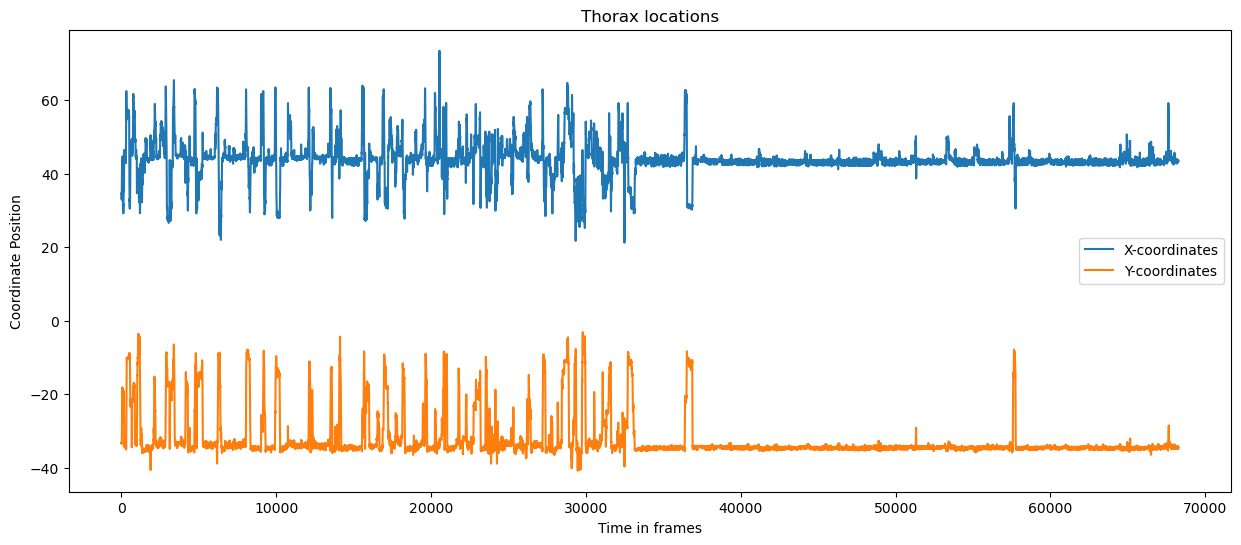

In [106]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

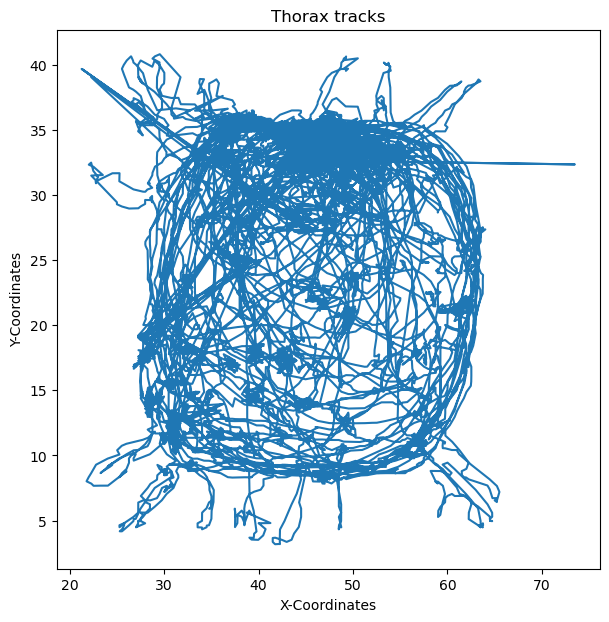

In [107]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


## Creating an individual column for each pose tracking

In [108]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset="current_subject")

In [109]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
1            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
2            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
3            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
4            1       32200      [1.1, 1.2]        [1.1, 1.2]           1   

   Unnamed: 7 Unnamed: 8                                         sleap_name  \
0         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
1         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
2         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
3         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
4         NaN        NaN  20230614_114041_standard_comp_to_training_D3_s...   

                                          video_name current_subject  ...  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1  ...   
1  20230612_112630_standard_comp_to_training_D1_s...             1.2  ...   
2  20230613_105657_standard_comp_to_training_D2_s...             1.1  ...   
3  20230613_105657_standard_comp_to_training_D2_s...             1.4  ...   
4  20230614_114041_standard_comp_to_training_D3_s...             1.1  ...   

  average_height average_width width_ratio height_ratio  \
0     266.715544    209.768379    0.140631     0.089984   
1     266.715544    209.768379    0.140631     0.089984   
2     263.215010    212.368779    0.138909     0.091180   
3     263.215010    212.368779    0.138909     0.091180   
4     260.889234    212.714155    0.138684     0.091993   

                                  rescaled_locations  \
0  {'1.1': [[[34.25438031 35.66763544], [34.76795...   
1  {'1.1': [[[34.25438031 35.66763544], [34.76795...   
2  {'1.1': [[[47.19772262 36.49884996], [43.93209...   
3  {'1.1': [[[47.19772262 36.49884996], [43.93209...   
4  {'1.1': [[[52.51888343 36.28326548], [52.00764...   

                              box_top_left  \
0   [30.24932345912479, 10.25122851487125]   
1   [30.24932345912479, 10.25122851487125]   
2  [29.42717788149638, 10.939657307701639]   
3  [29.42717788149638, 10.939657307701639]   
4  [29.10707058981441, 11.364487226798616]   

                              box_top_right  \
0  [59.816912963855586, 10.100544626940918]   
1  [59.816912963855586, 10.100544626940918]   
2   [58.80982189308497, 10.239514076824564]   
3   [58.80982189308497, 10.239514076824564]   
4  [58.883863567261514, 10.806271116252097]   

                              reward_port  \
0  [45.23441700698972, 35.83828707637651]   
1  [45.23441700698972, 35.83828707637651]   
2  [45.31189572048577, 36.38317068198775]   
3  [45.31189572048577, 36.38317068198775]   
4  [45.44232917370965, 36.91440422283628]   

                           box_bottom_left  \
0  [30.458913657178506, 34.21867013031604]   
1  [30.458913657178506, 34.21867013031604]   
2  [30.490085836306232, 34.91627159792731]   
3  [30.490085836306232, 34.91627159792731]   
4  [30.339373669373565, 35.17083382117832]   

                          box_bottom_right  
0   [59.89132415244771, 34.13310301149612]  
1   [59.89132415244771, 34.13310301149612]  
2  [60.10744182471764, 34.262899786598894]  
3  [60.10744182471764, 34.262899786598894]  
4  [59.562580691926456, 34.99992452187238]  

[5 rows x 34 columns]

In [110]:
START_STOP_FRAME_DF["tracked_subject"]

0     [1.1, 1.2]
1     [1.1, 1.2]
2     [1.1, 1.4]
3     [1.1, 1.4]
4     [1.1, 1.2]
5     [1.1, 1.2]
6     [1.2, 1.4]
7     [1.2, 1.4]
8     [1.1, 1.4]
9     [1.1, 1.4]
10    [1.1, 1.2]
11    [1.1, 1.2]
12    [1.2, 1.4]
13    [1.2, 1.4]
14    [3.1, 3.3]
15    [3.1, 3.3]
16    [4.2, 4.3]
17    [4.2, 4.3]
18    [3.3, 3.4]
19    [3.3, 3.4]
20    [4.3, 4.4]
21    [4.3, 4.4]
22    [3.1, 3.4]
23    [3.1, 3.4]
24    [4.2, 4.4]
25    [4.2, 4.4]
26    [5.3, 5.4]
27    [5.3, 5.4]
28    [5.2, 5.3]
29    [5.2, 5.3]
30    [4.2, 4.3]
31    [4.2, 4.3]
32    [3.3, 3.4]
33    [3.3, 3.4]
34    [4.3, 4.4]
35    [4.3, 4.4]
36    [5.2, 5.3]
37    [5.2, 5.3]
38    [3.1, 3.4]
39    [3.1, 3.4]
40    [4.2, 4.4]
41    [4.2, 4.4]
42    [4.2, 4.3]
43    [4.2, 4.3]
44    [3.1, 3.3]
45    [3.1, 3.3]
46    [4.3, 4.4]
47    [4.3, 4.4]
48    [3.3, 3.4]
49    [3.3, 3.4]
50    [5.3, 5.4]
51    [5.3, 5.4]
52    [5.2, 5.3]
53    [5.2, 5.3]
54    [5.2, 5.4]
55    [5.2, 5.4]
56    [3.1, 3.4]
57    [3.1, 3.4]
58    [4.2, 4.

In [111]:
START_STOP_FRAME_DF["agent"] = START_STOP_FRAME_DF.apply(lambda x: list((set(x["tracked_subject"]) - set([x["current_subject"]]))), axis=1)

In [112]:
START_STOP_FRAME_DF[START_STOP_FRAME_DF["agent"].apply(lambda x: len(x) != 1)]

Empty DataFrame
Columns: [start_frame, stop_frame, tracked_subject, in_video_subjects, box_number, Unnamed: 7, Unnamed: 8, sleap_name, video_name, current_subject, sleap_glob, sleap_path, all_sleap_data, body_parts, locations, track_names, subject_to_index, subject_to_tracks, corner_path, corner_parts, bottom_width, top_width, right_height, left_height, average_height, average_width, width_ratio, height_ratio, rescaled_locations, box_top_left, box_top_right, reward_port, box_bottom_left, box_bottom_right, agent]
Index: []

[0 rows x 35 columns]

In [113]:
START_STOP_FRAME_DF["agent"] = START_STOP_FRAME_DF["agent"].apply(lambda x: x[0] if len(x) == 1 else None)

In [114]:
START_STOP_FRAME_DF["agent"]

0     1.2
1     1.1
2     1.4
3     1.1
4     1.2
5     1.1
6     1.4
7     1.2
8     1.4
9     1.1
10    1.2
11    1.1
12    1.4
13    1.2
14    3.3
15    3.1
16    4.3
17    4.2
18    3.4
19    3.3
20    4.4
21    4.3
22    3.4
23    3.1
24    4.4
25    4.2
26    5.4
27    5.3
28    5.3
29    5.2
30    4.3
31    4.2
32    3.4
33    3.3
34    4.4
35    4.3
36    5.3
37    5.2
38    3.4
39    3.1
40    4.4
41    4.2
42    4.3
43    4.2
44    3.3
45    3.1
46    4.4
47    4.3
48    3.4
49    3.3
50    5.4
51    5.3
52    5.3
53    5.2
54    5.4
55    5.2
56    3.4
57    3.1
58    4.4
59    4.2
Name: agent, dtype: object

In [115]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
1            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
2            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
3            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
4            1       32200      [1.1, 1.2]        [1.1, 1.2]           1   

   Unnamed: 7 Unnamed: 8                                         sleap_name  \
0         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
1         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
2         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
3         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
4         NaN        NaN  20230614_114041_standard_comp_to_training_D3_s...   

                                          video_name current_subject  ...  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1  ...   
1  20230612_112630_standard_comp_to_training_D1_s...             1.2  ...   
2  20230613_105657_standard_comp_to_training_D2_s...             1.1  ...   
3  20230613_105657_standard_comp_to_training_D2_s...             1.4  ...   
4  20230614_114041_standard_comp_to_training_D3_s...             1.1  ...   

  average_width width_ratio height_ratio  \
0    209.768379    0.140631     0.089984   
1    209.768379    0.140631     0.089984   
2    212.368779    0.138909     0.091180   
3    212.368779    0.138909     0.091180   
4    212.714155    0.138684     0.091993   

                                  rescaled_locations  \
0  {'1.1': [[[34.25438031 35.66763544], [34.76795...   
1  {'1.1': [[[34.25438031 35.66763544], [34.76795...   
2  {'1.1': [[[47.19772262 36.49884996], [43.93209...   
3  {'1.1': [[[47.19772262 36.49884996], [43.93209...   
4  {'1.1': [[[52.51888343 36.28326548], [52.00764...   

                              box_top_left  \
0   [30.24932345912479, 10.25122851487125]   
1   [30.24932345912479, 10.25122851487125]   
2  [29.42717788149638, 10.939657307701639]   
3  [29.42717788149638, 10.939657307701639]   
4  [29.10707058981441, 11.364487226798616]   

                              box_top_right  \
0  [59.816912963855586, 10.100544626940918]   
1  [59.816912963855586, 10.100544626940918]   
2   [58.80982189308497, 10.239514076824564]   
3   [58.80982189308497, 10.239514076824564]   
4  [58.883863567261514, 10.806271116252097]   

                              reward_port  \
0  [45.23441700698972, 35.83828707637651]   
1  [45.23441700698972, 35.83828707637651]   
2  [45.31189572048577, 36.38317068198775]   
3  [45.31189572048577, 36.38317068198775]   
4  [45.44232917370965, 36.91440422283628]   

                           box_bottom_left  \
0  [30.458913657178506, 34.21867013031604]   
1  [30.458913657178506, 34.21867013031604]   
2  [30.490085836306232, 34.91627159792731]   
3  [30.490085836306232, 34.91627159792731]   
4  [30.339373669373565, 35.17083382117832]   

                          box_bottom_right agent  
0   [59.89132415244771, 34.13310301149612]   1.2  
1   [59.89132415244771, 34.13310301149612]   1.1  
2  [60.10744182471764, 34.262899786598894]   1.4  
3  [60.10744182471764, 34.262899786598894]   1.1  
4  [59.562580691926456, 34.99992452187238]   1.2  

[5 rows x 35 columns]

In [116]:
START_STOP_FRAME_DF["subject_locations"] = START_STOP_FRAME_DF.apply(lambda x: x["rescaled_locations"][x["current_subject"]] , axis=1)

In [117]:
START_STOP_FRAME_DF["agent_locations"] = START_STOP_FRAME_DF.apply(lambda x: x["rescaled_locations"].get(x["agent"], np.nan) if x["agent"] else np.nan, axis=1)

## Getting all the timestamps

In [118]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'Unnamed: 7', 'Unnamed: 8', 'sleap_name', 'video_name',
       'current_subject', 'sleap_glob', 'sleap_path', 'all_sleap_data',
       'body_parts', 'locations', 'track_names', 'subject_to_index',
       'subject_to_tracks', 'corner_path', 'corner_parts', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'rescaled_locations',
       'box_top_left', 'box_top_right', 'reward_port', 'box_bottom_left',
       'box_bottom_right', 'agent', 'subject_locations', 'agent_locations'],
      dtype='object')

In [119]:
START_STOP_FRAME_DF["frame_index"] = START_STOP_FRAME_DF["subject_locations"].apply(lambda x: np.arange(0, x.shape[0]) + 1)

## Removing unnecessary columns

In [120]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(["sleap_glob", "subject_to_index", "subject_to_tracks", "corner_parts", "corner_to_coordinate", "bottom_width", "top_width", "right_height", "left_height", "average_height", "average_width", "width_ratio", "height_ratio", 'locations', 'track_names', 'sleap_path', 'corner_path', 'all_sleap_data', 'rescaled_locations'], errors="ignore", axis=1)

In [121]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'Unnamed: 7', 'Unnamed: 8', 'sleap_name', 'video_name',
       'current_subject', 'body_parts', 'box_top_left', 'box_top_right',
       'reward_port', 'box_bottom_left', 'box_bottom_right', 'agent',
       'subject_locations', 'agent_locations', 'frame_index'],
      dtype='object')

In [122]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
1            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
2            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
3            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
4            1       32200      [1.1, 1.2]        [1.1, 1.2]           1   

   Unnamed: 7 Unnamed: 8                                         sleap_name  \
0         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
1         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
2         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
3         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
4         NaN        NaN  20230614_114041_standard_comp_to_training_D3_s...   

                                          video_name current_subject  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1   
1  20230612_112630_standard_comp_to_training_D1_s...             1.2   
2  20230613_105657_standard_comp_to_training_D2_s...             1.1   
3  20230613_105657_standard_comp_to_training_D2_s...             1.4   
4  20230614_114041_standard_comp_to_training_D3_s...             1.1   

                                          body_parts  \
0  [left_ear, right_ear, nose, tail_base, thorax,...   
1  [left_ear, right_ear, nose, tail_base, thorax,...   
2  [left_ear, right_ear, nose, tail_base, thorax,...   
3  [left_ear, right_ear, nose, tail_base, thorax,...   
4  [left_ear, right_ear, nose, tail_base, thorax,...   

                              box_top_left  \
0   [30.24932345912479, 10.25122851487125]   
1   [30.24932345912479, 10.25122851487125]   
2  [29.42717788149638, 10.939657307701639]   
3  [29.42717788149638, 10.939657307701639]   
4  [29.10707058981441, 11.364487226798616]   

                              box_top_right  \
0  [59.816912963855586, 10.100544626940918]   
1  [59.816912963855586, 10.100544626940918]   
2   [58.80982189308497, 10.239514076824564]   
3   [58.80982189308497, 10.239514076824564]   
4  [58.883863567261514, 10.806271116252097]   

                              reward_port  \
0  [45.23441700698972, 35.83828707637651]   
1  [45.23441700698972, 35.83828707637651]   
2  [45.31189572048577, 36.38317068198775]   
3  [45.31189572048577, 36.38317068198775]   
4  [45.44232917370965, 36.91440422283628]   

                           box_bottom_left  \
0  [30.458913657178506, 34.21867013031604]   
1  [30.458913657178506, 34.21867013031604]   
2  [30.490085836306232, 34.91627159792731]   
3  [30.490085836306232, 34.91627159792731]   
4  [30.339373669373565, 35.17083382117832]   

                          box_bottom_right agent  \
0   [59.89132415244771, 34.13310301149612]   1.2   
1   [59.89132415244771, 34.13310301149612]   1.1   
2  [60.10744182471764, 34.262899786598894]   1.4   
3  [60.10744182471764, 34.262899786598894]   1.1   
4  [59.562580691926456, 34.99992452187238]   1.2   

                                   subject_locations  \
0  [[[34.25438031064355, 35.667635444835575], [34...   
1  [[[47.229714341638875, 11.540576985831455], [4...   
2  [[[47.197722618012605, 36.49884996438671], [43...   
3  [[[50.364208780909664, 10.861847428311039], [5...   
4  [[[52.518883426095876, 36.28326548413289], [52...   

                                     agent_locations  \
0  [[[47.229714341638875, 11.540576985831455], [4...   
1  [[[34.25438031064355, 35.667635444835575], [34...   
2  [[[50.364208780909664, 10.861847428311039], [5...   
3  [[[47.197722618012605, 36.49884996438671], [43...   
4  [[[44.894543657007155, 33.83744818008539], [44...   

                                         frame_index  
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12

# Calculate relavant features

## Features to calculate

1. velocity of the mice
2. distance between thoraxes
3. distances to port of mice
4. angles of orientation of mice to port




Original features to calculate
1. distance between thoraxes
2. velocity of mouse 1 + velocity of mouse 2
3. | velocity of mouse 1 - velocity of mouse 2 |
4. sum of angles of orientation of mice to port
5. | difference of angles of orientation of mice to port |
6. sum of distances to port of mice
7. | differences of distances to port of mice |

In [123]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'Unnamed: 7', 'Unnamed: 8', 'sleap_name', 'video_name',
       'current_subject', 'body_parts', 'box_top_left', 'box_top_right',
       'reward_port', 'box_bottom_left', 'box_bottom_right', 'agent',
       'subject_locations', 'agent_locations', 'frame_index'],
      dtype='object')

# Getting relavent body parts

In [124]:
START_STOP_FRAME_DF["body_parts"].apply(lambda x: x.index("thorax"))

0     4
1     4
2     4
3     4
4     4
5     4
6     4
7     4
8     4
9     4
10    4
11    4
12    4
13    4
14    4
15    4
16    4
17    4
18    4
19    4
20    4
21    4
22    4
23    4
24    4
25    4
26    4
27    4
28    4
29    4
30    4
31    4
32    4
33    4
34    4
35    4
36    4
37    4
38    4
39    4
40    4
41    4
42    4
43    4
44    4
45    4
46    4
47    4
48    4
49    4
50    4
51    4
52    4
53    4
54    4
55    4
56    4
57    4
58    4
59    4
Name: body_parts, dtype: int64

In [125]:
START_STOP_FRAME_DF["subject_thorax"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_locations"][:,x["body_parts"].index("thorax"),:], axis=1)
START_STOP_FRAME_DF["subject_nose"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_locations"][:,x["body_parts"].index("nose"),:], axis=1)
START_STOP_FRAME_DF["subject_tail_base"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_locations"][:,x["body_parts"].index("tail_base"),:], axis=1)


In [126]:
START_STOP_FRAME_DF["agent_thorax"] = START_STOP_FRAME_DF.apply(lambda x: x["agent_locations"][:,x["body_parts"].index("thorax"),:], axis=1)
START_STOP_FRAME_DF["agent_nose"] = START_STOP_FRAME_DF.apply(lambda x: x["agent_locations"][:,x["body_parts"].index("nose"),:], axis=1)
START_STOP_FRAME_DF["agent_tail_base"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_locations"][:,x["body_parts"].index("tail_base"),:], axis=1)


In [127]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
1            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
2            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
3            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
4            1       32200      [1.1, 1.2]        [1.1, 1.2]           1   

   Unnamed: 7 Unnamed: 8                                         sleap_name  \
0         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
1         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
2         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
3         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
4         NaN        NaN  20230614_114041_standard_comp_to_training_D3_s...   

                                          video_name current_subject  ...  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1  ...   
1  20230612_112630_standard_comp_to_training_D1_s...             1.2  ...   
2  20230613_105657_standard_comp_to_training_D2_s...             1.1  ...   
3  20230613_105657_standard_comp_to_training_D2_s...             1.4  ...   
4  20230614_114041_standard_comp_to_training_D3_s...             1.1  ...   

  agent                                  subject_locations  \
0   1.2  [[[34.25438031064355, 35.667635444835575], [34...   
1   1.1  [[[47.229714341638875, 11.540576985831455], [4...   
2   1.4  [[[47.197722618012605, 36.49884996438671], [43...   
3   1.1  [[[50.364208780909664, 10.861847428311039], [5...   
4   1.2  [[[52.518883426095876, 36.28326548413289], [52...   

                                     agent_locations  \
0  [[[47.229714341638875, 11.540576985831455], [4...   
1  [[[34.25438031064355, 35.667635444835575], [34...   
2  [[[50.364208780909664, 10.861847428311039], [5...   
3  [[[47.197722618012605, 36.49884996438671], [43...   
4  [[[44.894543657007155, 33.83744818008539], [44...   

                                         frame_index  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                      subject_thorax  \
0  [[39.52385035395619, 34.4047879939674], [39.75...   
1  [[45.00564713899357, 9.423307742464585], [45.0...   
2  [[49.63542666038801, 33.24704611284072], [48.9...   
3  [[56.28849066093229, 10.712517155668237], [56....   
4  [[56.24421089782916, 34.33473514950827], [56.4...   

                                        subject_nose  \
0  [[32.24815257269072, 34.21344397609933], [32.2...   
1  [[45.26381166791732, 14.406486324022024], [45....   
2  [[44.697651823519216, 37.62940888611388], [44....   
3  [[48.116585135368, 8.74652456522477], [47.9209...   
4  [[49.04541968974865, 35.322835211224344], [49....   

                                   subject_tail_base  \
0  [[43.24533105018797, 34.074110688844804], [43....   
1  [[49.00673383082635, 9.416220799854717], [48.7...   
2  [[50.617745398002654, 29.99575147694706], [50....   
3  [[57.54119673883656, 13.63503656650984], [57.5...   
4  [[57.46994633261048, 32.37899539750766], [57.4...   

                                        agent_thorax  \
0  [[45.00564713899357, 9.423307742464585], [45.0...   
1  [[39.52385035395619, 34.4047879939674], [39.75...   
2  [[56.28849066093229, 10.712517155668237], [56....   
3  [[49.63542666038801, 33.24704611284072], [48.9...   
4  [[40.41122526918516, 34.682322834375185], [40....   

                                          agent_nose  \
0  [[45.26381166791732, 14.406486324022024], [45....   
1  [[32.24815257269072, 34.21344397609933], [32.2...   
2  [[48.116585135368, 8.74652456522477], [47.

# Calculate velocity

In [128]:
START_STOP_FRAME_DF["subject_thorax_velocity"] = START_STOP_FRAME_DF.apply(lambda x: compute_velocity(x["subject_thorax"], window_size=FRAME_RATE*3) * FRAME_RATE, axis=1)
START_STOP_FRAME_DF["subject_thorax_velocity"] = START_STOP_FRAME_DF["subject_thorax_velocity"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [129]:
START_STOP_FRAME_DF["agent_locations"]

0     [[[47.229714341638875, 11.540576985831455], [4...
1     [[[34.25438031064355, 35.667635444835575], [34...
2     [[[50.364208780909664, 10.861847428311039], [5...
3     [[[47.197722618012605, 36.49884996438671], [43...
4     [[[44.894543657007155, 33.83744818008539], [44...
5     [[[52.518883426095876, 36.28326548413289], [52...
6     [[[57.357293717186636, 25.35640085901091], [54...
7     [[[51.89490721121774, 31.350052581765752], [55...
8     [[[29.382872218826854, 31.230168277565216], [3...
9     [[[47.25739785799209, 36.66551965695182], [44....
10    [[[43.00100040500416, 33.44266356014549], [41....
11    [[[30.292726450463043, 12.190622669129132], [3...
12    [[[51.667899971194274, 35.99393556831118], [49...
13    [[[50.88389901523767, 23.532566654286455], [51...
14    [[[51.049592291310574, 19.27532173433335], [54...
15    [[[58.961398589179765, 35.28935156776581], [57...
16    [[[59.070922225644495, 9.032051361034663], [61...
17    [[[62.54046053502408, 34.646917855927946],

In [130]:
START_STOP_FRAME_DF["agent_thorax_velocity"] = START_STOP_FRAME_DF.apply(lambda x: compute_velocity(x["agent_thorax"], window_size=FRAME_RATE*3) * FRAME_RATE if x["agent_locations"] is not np.nan else np.nan, axis=1)
START_STOP_FRAME_DF["agent_thorax_velocity"] = START_STOP_FRAME_DF["agent_thorax_velocity"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)


In [131]:
START_STOP_FRAME_DF["subject_thorax_velocity"].iloc[0].shape

(68258,)

## Calculate relavant distances

1. distance between thoraxes

In [132]:
START_STOP_FRAME_DF["subject_thorax_to_agent_thorax"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_thorax"] - x["agent_thorax"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_thorax_to_agent_thorax"] = START_STOP_FRAME_DF["subject_thorax_to_agent_thorax"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [133]:
START_STOP_FRAME_DF["subject_nose_to_agent_tail_base"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_nose"] - x["agent_tail_base"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_nose_to_agent_tail_base"] = START_STOP_FRAME_DF["subject_nose_to_agent_tail_base"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [134]:
START_STOP_FRAME_DF["subject_tail_base_to_agent_nose"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_tail_base"] - x["agent_nose"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_tail_base_to_agent_nose"] = START_STOP_FRAME_DF["subject_tail_base_to_agent_nose"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

2. distances to port of mice

In [135]:
START_STOP_FRAME_DF["subject_thorax_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_thorax"] - x["reward_port"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_thorax_to_reward_port"] = START_STOP_FRAME_DF["subject_thorax_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [136]:
START_STOP_FRAME_DF["agent_thorax_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["agent_thorax"] - x["reward_port"], axis=1) if x["agent_locations"] is not np.nan else np.nan,  axis=1)
START_STOP_FRAME_DF["agent_thorax_to_reward_port"] = START_STOP_FRAME_DF["agent_thorax_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [137]:
START_STOP_FRAME_DF["subject_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_nose"] - x["reward_port"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_nose_to_reward_port"] = START_STOP_FRAME_DF["subject_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [138]:
START_STOP_FRAME_DF["agent_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["agent_nose"] - x["reward_port"], axis=1),  axis=1)
START_STOP_FRAME_DF["agent_nose_to_reward_port"] = START_STOP_FRAME_DF["agent_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

- Calculate y distances

In [139]:

START_STOP_FRAME_DF["subject_x_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_nose"][:,0] - x["reward_port"][0]),  axis=1)
START_STOP_FRAME_DF["subject_x_nose_to_reward_port"] = START_STOP_FRAME_DF["subject_x_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)


START_STOP_FRAME_DF["subject_y_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_nose"][:,1] - x["reward_port"][1]),  axis=1)
START_STOP_FRAME_DF["subject_y_nose_to_reward_port"] = START_STOP_FRAME_DF["subject_y_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [140]:

START_STOP_FRAME_DF["agent_x_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["agent_nose"][:,0] - x["reward_port"][0]),  axis=1)
START_STOP_FRAME_DF["agent_x_nose_to_reward_port"] = START_STOP_FRAME_DF["agent_x_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)


START_STOP_FRAME_DF["agent_y_nose_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["agent_nose"][:,1] - x["reward_port"][1]),  axis=1)
START_STOP_FRAME_DF["agent_y_nose_to_reward_port"] = START_STOP_FRAME_DF["agent_y_nose_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

## Calculate to speed

In [141]:
START_STOP_FRAME_DF["subject_speed_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: calculate_speed_from_distances(x["subject_thorax_to_reward_port"], window_size=FRAME_RATE*3),  axis=1)
START_STOP_FRAME_DF["subject_speed_to_reward_port"] = START_STOP_FRAME_DF["subject_speed_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [142]:
START_STOP_FRAME_DF["agent_speed_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: calculate_speed_from_distances(x["agent_thorax_to_reward_port"], window_size=FRAME_RATE*3), axis=1)
START_STOP_FRAME_DF["agent_speed_to_reward_port"] = START_STOP_FRAME_DF["agent_speed_to_reward_port"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [143]:
START_STOP_FRAME_DF["subject_to_agent_speed"] = START_STOP_FRAME_DF.apply(lambda x: calculate_speed_from_distances(x["subject_thorax_to_agent_thorax"], window_size=FRAME_RATE*3), axis=1)
START_STOP_FRAME_DF["subject_to_agent_speed"] = START_STOP_FRAME_DF["subject_to_agent_speed"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

## Calculating orientation of the mouse

4. angles of orientation of mice to port

In [144]:
START_STOP_FRAME_DF["subject_to_reward_port_angle"] = START_STOP_FRAME_DF.apply(lambda x: calculate_time_series_angles(x["subject_thorax"], x["subject_nose"], np.tile(x["reward_port"], (x["subject_nose"].shape[0], 1))),  axis=1)
START_STOP_FRAME_DF["subject_to_reward_port_angle"] = START_STOP_FRAME_DF["subject_to_reward_port_angle"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [145]:
START_STOP_FRAME_DF["agent_to_reward_port_angle"] = START_STOP_FRAME_DF.apply(lambda x: calculate_time_series_angles(x["agent_thorax"], x["agent_nose"], np.tile(x["reward_port"], (x["agent_nose"].shape[0], 1))),  axis=1)
START_STOP_FRAME_DF["agent_to_reward_port_angle"] = START_STOP_FRAME_DF["agent_to_reward_port_angle"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [146]:
START_STOP_FRAME_DF["subject_to_agent_orientation"] = START_STOP_FRAME_DF.apply(lambda x: calculate_angles_from_arrays(x["subject_thorax"], x["subject_nose"], x["agent_thorax"], x["agent_nose"]),  axis=1)
START_STOP_FRAME_DF["subject_to_agent_orientation"] = START_STOP_FRAME_DF["subject_to_agent_orientation"].apply(lambda x: x.astype(np.float32) if x is not np.nan else np.nan)

In [147]:
START_STOP_FRAME_DF.head()

start_frame  stop_frame tracked_subject in_video_subjects  box_number  \
0            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
1            1       32300      [1.1, 1.2]        [1.1, 1.2]           1   
2            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
3            1       33000      [1.1, 1.4]        [1.1, 1.4]           1   
4            1       32200      [1.1, 1.2]        [1.1, 1.2]           1   

   Unnamed: 7 Unnamed: 8                                         sleap_name  \
0         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
1         NaN        NaN  20230612_112630_standard_comp_to_training_D1_s...   
2         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
3         NaN        NaN  20230613_105657_standard_comp_to_training_D2_s...   
4         NaN        NaN  20230614_114041_standard_comp_to_training_D3_s...   

                                          video_name current_subject  ...  \
0  20230612_112630_standard_comp_to_training_D1_s...             1.1  ...   
1  20230612_112630_standard_comp_to_training_D1_s...             1.2  ...   
2  20230613_105657_standard_comp_to_training_D2_s...             1.1  ...   
3  20230613_105657_standard_comp_to_training_D2_s...             1.4  ...   
4  20230614_114041_standard_comp_to_training_D3_s...             1.1  ...   

                       subject_x_nose_to_reward_port  \
0  [12.986264, 13.002249, 12.984807, 12.73218, 12...   
1  [0.02939466, 0.036737807, 0.49325183, 0.492874...   
2  [0.6142439, 0.39137772, 0.104911186, 1.1019015...   
3  [2.8046894, 2.6090896, 2.370157, 1.382128, 0.8...   
4  [3.6030905, 3.8228946, 4.1357074, 4.855519, 5....   

                       subject_y_nose_to_reward_port  \
0  [1.6248431, 1.748845, 1.4304345, 1.1190923, 1....   
1  [21.4318, 21.580795, 21.447683, 21.134186, 21....   
2  [1.2462382, 1.7116668, 2.0238328, 2.6693985, 3...   
3  [27.636646, 27.779207, 27.960299, 27.640125, 2...   
4  [1.5915691, 1.7534497, 2.0818992, 1.750297, 1....   

                         agent_x_nose_to_reward_port  \
0  [0.02939466, 0.036737807, 0.49325183, 0.492874...   
1  [12.986264, 13.002249, 12.984807, 12.73218, 12...   
2  [2.8046894, 2.6090896, 2.370157, 1.382128, 0.8...   
3  [0.6142439, 0.39137772, 0.104911186, 1.1019015...   
4  [2.656572, 2.9194355, 2.9285858, 3.1543236, 3....   

                         agent_y_nose_to_reward_port  \
0  [21.4318, 21.580795, 21.447683, 21.134186, 21....   
1  [1.6248431, 1.748845, 1.4304345, 1.1190923, 1....   
2  [27.636646, 27.779207, 27.960299, 27.640125, 2...   
3  [1.2462382, 1.7116668, 2.0238328, 2.6693985, 3...   
4  [0.9431285, 1.0928419, 0.9413627, 0.7627836, 0...   

                        subject_speed_to_reward_port  \
0  [-0.1674488, -0.14182994, -0.1170139, -0.09300...   
1  [-0.11912113, -0.10276413, -0.087192446, -0.07...   
2  [0.08416665, 0.0829623, 0.08169988, 0.08037941...   
3  [0.034613103, 0.028302655, 0.022200638, 0.0163...   
4  [-0.67976445, -0.60351384, -0.5297106, -0.4583...   

                          agent_speed_to_reward_port  \
0  [-0.11912113, -0.10276413, -0.087192446, -0.07...   
1  [-0.1674488, -0.14182994, -0.1170139, -0.09300...   
2  [0.034613103, 0.028302655, 0.022200638, 0.0163...   
3  [0.08416665, 0.0829623, 0.08169988, 0.08037941...   
4  [-0.06585696, -0.06609504, -0.06601468, -0.065...   

                              subject_to_agent_speed  \
0  [0.5456792, 0.49123406, 0.4381924, 0.3865542, ...   
1  [0.5456792, 0.49123406, 0.4381924, 0.3865542, ...   
2  [-0.017936064, -0.024800126, -0.031360313, -0....   
3  [-0.017936064, -0.024800126, -0.031360313, -0....   
4  [-0.20459369, -0.18008342, -0.15617444, -0.132...   

                        subject_to_reward_port_angle  \
0  [0.09818027, 0.091548294, 0.11449435, 0.154805...   
1  [3.0884602, 3.0866938, 3.057858, 3.0674672, 3....   
2  [0.38698635, 0.46056488, 0.55437726, 0.7595057...   
3  [1.4358417, 1.4404571,

# Making features based on social

In [148]:
START_STOP_FRAME_DF["thorax_velocity_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_thorax_velocity"] + x["agent_thorax_velocity"], axis=1)
START_STOP_FRAME_DF["thorax_velocity_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_thorax_velocity"] - x["agent_thorax_velocity"]), axis=1)

In [149]:
START_STOP_FRAME_DF["thorax_to_reward_port_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_thorax_to_reward_port"] + x["agent_thorax_to_reward_port"], axis=1)
START_STOP_FRAME_DF["thorax_to_reward_port_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_thorax_to_reward_port"] - x["agent_thorax_to_reward_port"]), axis=1)

In [150]:
START_STOP_FRAME_DF["nose_to_reward_port_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_nose_to_reward_port"] + x["agent_nose_to_reward_port"], axis=1)
START_STOP_FRAME_DF["nose_to_reward_port_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_nose_to_reward_port"] - x["agent_nose_to_reward_port"]), axis=1)

In [151]:
START_STOP_FRAME_DF["to_reward_port_angle_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_to_reward_port_angle"] + x["agent_to_reward_port_angle"], axis=1)
START_STOP_FRAME_DF["to_reward_port_angle_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_to_reward_port_angle"] - x["agent_to_reward_port_angle"]), axis=1)

In [152]:
START_STOP_FRAME_DF["nose_to_tail_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_tail_base_to_agent_nose"] + x["subject_nose_to_agent_tail_base"], axis=1)
START_STOP_FRAME_DF["nose_to_tail_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_tail_base_to_agent_nose"] - x["subject_nose_to_agent_tail_base"]), axis=1)

In [153]:
START_STOP_FRAME_DF["speed_to_reward_port_sum"] = START_STOP_FRAME_DF.apply(lambda x: x["subject_speed_to_reward_port"] + x["agent_speed_to_reward_port"], axis=1)
START_STOP_FRAME_DF["speed_to_reward_port_diff"] = START_STOP_FRAME_DF.apply(lambda x: np.abs(x["subject_speed_to_reward_port"] - x["agent_speed_to_reward_port"]), axis=1)

In [154]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'Unnamed: 7', 'Unnamed: 8', 'sleap_name', 'video_name',
       'current_subject', 'body_parts', 'box_top_left', 'box_top_right',
       'reward_port', 'box_bottom_left', 'box_bottom_right', 'agent',
       'subject_locations', 'agent_locations', 'frame_index', 'subject_thorax',
       'subject_nose', 'subject_tail_base', 'agent_thorax', 'agent_nose',
       'agent_tail_base', 'subject_thorax_velocity', 'agent_thorax_velocity',
       'subject_thorax_to_agent_thorax', 'subject_nose_to_agent_tail_base',
       'subject_tail_base_to_agent_nose', 'subject_thorax_to_reward_port',
       'agent_thorax_to_reward_port', 'subject_nose_to_reward_port',
       'agent_nose_to_reward_port', 'subject_x_nose_to_reward_port',
       'subject_y_nose_to_reward_port', 'agent_x_nose_to_reward_port',
       'agent_y_nose_to_reward_port', 'subject_speed_to_reward_port',
       'agent_speed_to_reward_port', 'subj

# Adding trial information

In [155]:
list_of_trials_df = []

for file_path in all_trials_files:
    current_df = pd.read_excel(file_path)
    list_of_trials_df.append(current_df)

trial_labels = pd.concat(list_of_trials_df)


In [156]:
trial_labels = trial_labels.dropna(subset=["condition ", "tone_start_frame"])

In [157]:
trial_labels["tone_start_frame"] = trial_labels["tone_start_frame"].astype(int)
trial_labels["tone_stop_frame"] = trial_labels["tone_stop_frame"].astype(int)

In [158]:
trial_labels["10s_before_tone_frame"] = trial_labels["tone_start_frame"] - 200
trial_labels["10s_after_tone_frame"] = trial_labels["tone_stop_frame"] + 200

In [159]:
trial_labels["tone_start_to_stop_frame"] = trial_labels.apply(lambda x: (int(x["tone_start_frame"]), int(x["tone_stop_frame"])), axis=1)

In [160]:
trial_labels.head()

Unnamed: 0                               session_dir  tone_start_frame  \
1         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              1737   
2         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              4730   
3         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              7597   
4         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              9841   
5         0.0  20240227_130241_comp_om_subj_4-2_and_4-3             11211   

   tone_stop_frame condition  competition_closeness  get_reward_frame  \
1             1988        tbd                   NaN               NaN   
2             4978        tbd                   NaN               NaN   
3             7846        tbd                   NaN               NaN   
4            10090        tbd                   NaN               NaN   
5            11462        tbd                   NaN               NaN   

   out_reward_frame notes experiment  ...  \
1               NaN   NaN        NaN  ...   
2               NaN   NaN        NaN  ...   
3               NaN   NaN        NaN  ...   
4               NaN   NaN        NaN  ...   
5               NaN   NaN        NaN  ...   

                         box_1_port_entry_timestamps  \
1  [1509237 1510837] [1511837 1519237] [1520037 1...   
2                                  [3965869 3998470]   
3  [6229499 6231496] [6232499 6235899] [6238099 6...   
4  [7895120 7896118] [7897121 7898518] [7899521 7...   
5                                                NaN   

  box_2_port_entry_timestamps reward_start reward_dispensed  \
1                         NaN          NaN              NaN   
2                         NaN          NaN              NaN   
3                         NaN          NaN              NaN   
4                         NaN          NaN              NaN   
5                         NaN          NaN              NaN   

   reward_start_frame  minutes  seconds  10s_before_tone_frame  \
1                 NaN      NaN      NaN                   1537   
2                 NaN      NaN      NaN                   4530   
3                 NaN      NaN      NaN                   7397   
4                 NaN      NaN      NaN                   9641   
5                 NaN      NaN      NaN                  11011   

  10s_after_tone_frame tone_start_to_stop_frame  
1                 2188             (1737, 1988)  
2                 5178             (4730, 4978)  
3                 8046             (7597, 7846)  
4                10290            (9841, 10090)  
5                11662           (11211, 11462)  

[5 rows x 28 columns]

In [161]:
trial_labels = trial_labels.dropna(subset=["condition "])

In [162]:
trial_labels["video_name"] = trial_labels["video_name"].apply(lambda x: x.replace(".videoTimeStamps.cameraHWSync", ""))

In [163]:
merged_trial_labels_df = pd.merge(left = trial_labels, right = START_STOP_FRAME_DF, on=["video_name"])

In [164]:
features_columns

['frame_index',
 'subject_thorax_to_agent_thorax',
 'thorax_to_reward_port_sum',
 'thorax_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [165]:
merged_trial_labels_df.head()

Unnamed: 0                               session_dir  tone_start_frame  \
0         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              1737   
1         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              1737   
2         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              4730   
3         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              4730   
4         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              7597   

   tone_stop_frame condition  competition_closeness  get_reward_frame  \
0             1988        tbd                   NaN               NaN   
1             1988        tbd                   NaN               NaN   
2             4978        tbd                   NaN               NaN   
3             4978        tbd                   NaN               NaN   
4             7846        tbd                   NaN               NaN   

   out_reward_frame notes experiment  ...  \
0               NaN   NaN        NaN  ...   
1               NaN   NaN        NaN  ...   
2               NaN   NaN        NaN  ...   
3               NaN   NaN        NaN  ...   
4               NaN   NaN        NaN  ...   

                           thorax_to_reward_port_sum  \
0  [35.565716, 36.925777, 37.55815, 38.08381, 38....   
1  [35.565716, 36.925777, 37.55815, 38.08381, 38....   
2  [35.565716, 36.925777, 37.55815, 38.08381, 38....   
3  [35.565716, 36.925777, 37.55815, 38.08381, 38....   
4  [35.565716, 36.925777, 37.55815, 38.08381, 38....   

                          thorax_to_reward_port_diff  \
0  [5.5918856, 4.482605, 3.6059532, 2.8095493, 1....   
1  [5.5918856, 4.482605, 3.6059532, 2.8095493, 1....   
2  [5.5918856, 4.482605, 3.6059532, 2.8095493, 1....   
3  [5.5918856, 4.482605, 3.6059532, 2.8095493, 1....   
4  [5.5918856, 4.482605, 3.6059532, 2.8095493, 1....   

                             nose_to_reward_port_sum  \
0  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
1  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
2  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
3  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
4  [44.000267, 43.478283, 42.28478, 40.977364, 41...   

                            nose_to_reward_port_diff  \
0  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
1  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
2  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
3  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
4  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   

                            to_reward_port_angle_sum  \
0  [1.4995296, 1.7782751, 2.0462985, 2.458772, 2....   
1  [1.4995296, 1.7782751, 2.0462985, 2.458772, 2....   
2  [1.4995296, 1.7782751, 2.0462985, 2.458772, 2....   
3  [1.4995296, 1.7782751, 2.0462985, 2.458772, 2....   
4  [1.4995296, 1.7782751, 2.0462985, 2.458772, 2....   

                           to_reward_port_angle_diff  \
0  [0.64296055, 0.93197334, 1.2767341, 1.5005012,...   
1  [0.64296055, 0.93197334, 1.2767341, 1.5005012,...   
2  [0.64296055, 0.93197334, 1.2767341, 1.5005012,...   
3  [0.64296055, 0.93197334, 1.2767341, 1.5005012,...   
4  [0.64296055, 0.93197334, 1.2767341, 1.5005012,...   

                                    nose_to_tail_sum  \
0  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   
1  [38.42459, 37.736725, 37.236202, 36.23296, 37....   
2  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   
3  [38.42459, 37.736725, 37.236202, 36.23296, 37....   
4  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   

                                   nose_to_tail_diff  \
0  [18.818794, 17.641945, 17.306507, 17.677742, 1...   
1  [18.192137, 19.137976, 20.054024, 19.669659, 2...   
2  [18.818794, 17.641945, 17.306507, 17.677742, 1...   
3  [18.192137, 19.137976, 20.054024, 19.669659, 2...   
4  [18.818794, 17.641945, 17.306507, 17.677742, 1...   

                            speed_to_reward_port_sum  \
0  [-0.2562998, -0.22657192, -0.19791257, -0.1703...   
1  [-0.2562998, -0.226

In [166]:
features_columns

['frame_index',
 'subject_thorax_to_agent_thorax',
 'thorax_to_reward_port_sum',
 'thorax_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [167]:
merged_trial_labels_df[features_columns]

frame_index  \
0     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
...                                                 ...   
1771  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1772  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1773  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1774  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1775  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                         subject_thorax_to_agent_thorax  \
0     [29.360085, 29.802845, 29.849094, 30.152153, 3...   
1     [29.360085, 29.802845, 29.849094, 30.152153, 3...   
2     [29.360085, 29.802845, 29.849094, 30.152153, 3...   
3     [29.360085, 29.802845, 29.849094, 30.152153, 3...   
4     [29.360085, 29.802845, 29.849094, 30.152153, 3...   
...                                                 ...   
1771  [13.973074, 13.654894, 13.505194, 13.2910185, ...   
1772  [13.973074, 13.654894, 13.505194, 13.2910185, ...   
1773  [13.973074, 13.654894, 13.505194, 13.2910185, ...   
1774  [13.973074, 13.654894, 13.505194, 13.2910185, ...   
1775  [13.973074, 13.654894, 13.505194, 13.2910185, ...   

                              thorax_to_reward_port_sum  \
0     [35.565716, 36.925777, 37.55815, 38.08381, 38....   
1     [35.565716, 36.925777, 37.55815, 38.08381, 38....   
2     [35.565716, 36.925777, 37.55815, 38.08381, 38....   
3     [35.565716, 36.925777, 37.55815, 38.08381, 38....   
4     [35.565716, 36.925777, 37.55815, 38.08381, 38....   
...                                                 ...   
1771  [25.234604, 24.754147, 24.771688, 24.830002, 2...   
1772  [25.234604, 24.754147, 24.771688, 24.830002, 2...   
1773  [25.234604, 24.754147, 24.771688, 24.830002, 2...   
1774  [25.234604, 24.754147, 24.771688, 24.830002, 2...   
1775  [25.234604, 24.754147, 24.771688, 24.830002, 2...   

                             thorax_to_reward_port_diff  \
0     [5.5918856, 4.482605, 3.6059532, 2.8095493, 1....   
1     [5.5918856, 4.482605, 3.6059532, 2.8095493, 1....   
2     [5.5918856, 4.482605, 3.6059532, 2.8095493, 1....   
3     [5.5918856, 4.482605, 3.6059532, 2.8095493, 1....   
4     [5.5918856, 4.482605, 3.6059532, 2.8095493, 1....   
...                                                 ...   
1771  [7.7184, 7.232787, 7.225445, 7.283104, 7.08720...   
1772  [7.7184, 7.232787, 7.225445, 7.283104, 7.08720...   
1773  [7.7184, 7.232787, 7.225445, 7.283104, 7.08720...   
1774  [7.7184, 7.232787, 7.225445, 7.283104, 7.08720...   
1775  [7.7184, 7.232787, 7.225445, 7.283104, 7.08720...   

                                    thorax_velocity_sum  \
0     [45.20549, 43.177635, 41.206642, 39.29226, 37....   
1     [45.20549, 43.177635, 41.206642, 39.29226, 37....   
2     [45.20549, 43.177635, 41.206642, 39.29226, 37....   
3     [45.20549, 43.177635, 41.206642, 39.29226, 37....   
4     [45.20549, 43.177635, 41.206642, 39.29226, 37....   
...                                                 ...   
1771  [24.115974, 22.53961, 21.000168, 19.497765, 18...   
1772  [24.115974, 22.53961, 21.000168, 19.497765, 18...   
1773  [24.115974, 22.53961, 21.000168, 19.497765, 18...   
1774  [24.115974, 22.53961, 21.000168, 19.497765, 18...   
1775  [24.115974, 22.53961, 21.000168, 19.497765, 18...   

                                   thorax_velocity_diff  \
0     [3.2388973, 2.7431622, 2.2632961, 1.7994633, 1...   
1     [3.2388973, 2.7431622, 2.2632961, 1.7994633, 1...   
2     [3.2388973, 2.7431622, 2.2632961, 1.7994633, 1...   
3     [3.2388973, 2.7431622, 2.2632961, 1.7994633, 1...   
4     [3.2388973, 2.7431622, 2.2632961, 1.7994633, 1...   
...                                                 ...   
1771  [2.7409468, 2.1827755, 1.6340685, 1.0949802, 0...   
1772  [2.7409468, 2.1827755

In [168]:
for col in features_columns:
    merged_trial_labels_df[col] = merged_trial_labels_df.apply(lambda x: x[col][int(x["10s_before_tone_frame"]): int(x["10s_after_tone_frame"])], axis=1)

    	

In [169]:
features_columns = [col for col in features_columns if col != "frame_index"]

In [170]:
features_columns

['subject_thorax_to_agent_thorax',
 'thorax_to_reward_port_sum',
 'thorax_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [171]:
merged_trial_labels_df.head()

Unnamed: 0                               session_dir  tone_start_frame  \
0         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              1737   
1         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              1737   
2         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              4730   
3         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              4730   
4         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              7597   

   tone_stop_frame condition  competition_closeness  get_reward_frame  \
0             1988        tbd                   NaN               NaN   
1             1988        tbd                   NaN               NaN   
2             4978        tbd                   NaN               NaN   
3             4978        tbd                   NaN               NaN   
4             7846        tbd                   NaN               NaN   

   out_reward_frame notes experiment  ...  \
0               NaN   NaN        NaN  ...   
1               NaN   NaN        NaN  ...   
2               NaN   NaN        NaN  ...   
3               NaN   NaN        NaN  ...   
4               NaN   NaN        NaN  ...   

                           thorax_to_reward_port_sum  \
0  [31.675985, 31.656166, 31.626007, 31.344654, 3...   
1  [31.675985, 31.656166, 31.626007, 31.344654, 3...   
2  [31.55321, 31.601624, 31.825798, 32.082405, 31...   
3  [31.55321, 31.601624, 31.825798, 32.082405, 31...   
4  [39.99805, 40.00112, 39.983807, 39.898605, 40....   

                          thorax_to_reward_port_diff  \
0  [24.4843, 24.73425, 24.736107, 25.019493, 25.3...   
1  [24.4843, 24.73425, 24.736107, 25.019493, 25.3...   
2  [22.245695, 22.210377, 22.2309, 22.260735, 22....   
3  [22.245695, 22.210377, 22.2309, 22.260735, 22....   
4  [19.12505, 19.118376, 19.126877, 19.027763, 19...   

                             nose_to_reward_port_sum  \
0  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
1  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
2  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
3  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
4  [44.000267, 43.478283, 42.28478, 40.977364, 41...   

                            nose_to_reward_port_diff  \
0  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
1  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
2  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
3  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
4  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   

                            to_reward_port_angle_sum  \
0  [1.7483872, 1.9265755, 2.0512965, 2.067646, 2....   
1  [1.7483872, 1.9265755, 2.0512965, 2.067646, 2....   
2  [3.117681, 3.200835, 3.3150315, 3.4069362, 3.5...   
3  [3.117681, 3.200835, 3.3150315, 3.4069362, 3.5...   
4  [5.5382996, 5.497998, 5.5058613, 5.5545154, 5....   

                           to_reward_port_angle_diff  \
0  [1.6420745, 1.4988881, 1.3512313, 1.3406278, 1...   
1  [1.6420745, 1.4988881, 1.3512313, 1.3406278, 1...   
2  [0.85365593, 0.77031755, 0.84500945, 0.7553247...   
3  [0.85365593, 0.77031755, 0.84500945, 0.7553247...   
4  [0.12354159, 0.1503017, 0.15393925, 0.09008694...   

                                    nose_to_tail_sum  \
0  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   
1  [38.42459, 37.736725, 37.236202, 36.23296, 37....   
2  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   
3  [38.42459, 37.736725, 37.236202, 36.23296, 37....   
4  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   

                                   nose_to_tail_diff  \
0  [18.818794, 17.641945, 17.306507, 17.677742, 1...   
1  [18.192137, 19.137976, 20.054024, 19.669659, 2...   
2  [18.818794, 17.641945, 17.306507, 17.677742, 1...   
3  [18.192137, 19.137976, 20.054024, 19.669659, 2...   
4  [18.818794, 17.641945, 17.306507, 17.677742, 1...   

                            speed_to_reward_port_sum  \
0  [-0.2562998, -0.22657192, -0.19791257, -0.1703...   
1  [-0.2562998, -0.226

In [172]:
merged_trial_labels_df.columns

Index(['Unnamed: 0', 'session_dir', 'tone_start_frame', 'tone_stop_frame',
       'condition ', 'competition_closeness', 'get_reward_frame',
       'out_reward_frame', 'notes', 'experiment', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'tone_start_timestamp',
       'tone_stop_timestamp', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'reward_start', 'reward_dispensed',
       'reward_start_frame', 'minutes', 'seconds', '10s_before_tone_frame',
       '10s_after_tone_frame', 'tone_start_to_stop_frame', 'start_frame',
       'stop_frame', 'tracked_subject', 'in_video_subjects', 'box_number',
       'Unnamed: 7', 'Unnamed: 8', 'sleap_name', 'current_subject',
       'body_parts', 'box_top_left', 'box_top_right', 'reward_port',
       'box_bottom_left', 'box_bottom_right', 'agent', 'subject_locations',
       'agent_locations', 'frame_index', 'subject_thorax', 'subject_nose',
  

In [173]:
# merged_trial_labels_df = merged_trial_labels_df.drop_duplicates(subset=["video_name", "tone_stop_frame"])

In [174]:
merged_trial_labels_df.head()

Unnamed: 0                               session_dir  tone_start_frame  \
0         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              1737   
1         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              1737   
2         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              4730   
3         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              4730   
4         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              7597   

   tone_stop_frame condition  competition_closeness  get_reward_frame  \
0             1988        tbd                   NaN               NaN   
1             1988        tbd                   NaN               NaN   
2             4978        tbd                   NaN               NaN   
3             4978        tbd                   NaN               NaN   
4             7846        tbd                   NaN               NaN   

   out_reward_frame notes experiment  ...  \
0               NaN   NaN        NaN  ...   
1               NaN   NaN        NaN  ...   
2               NaN   NaN        NaN  ...   
3               NaN   NaN        NaN  ...   
4               NaN   NaN        NaN  ...   

                           thorax_to_reward_port_sum  \
0  [31.675985, 31.656166, 31.626007, 31.344654, 3...   
1  [31.675985, 31.656166, 31.626007, 31.344654, 3...   
2  [31.55321, 31.601624, 31.825798, 32.082405, 31...   
3  [31.55321, 31.601624, 31.825798, 32.082405, 31...   
4  [39.99805, 40.00112, 39.983807, 39.898605, 40....   

                          thorax_to_reward_port_diff  \
0  [24.4843, 24.73425, 24.736107, 25.019493, 25.3...   
1  [24.4843, 24.73425, 24.736107, 25.019493, 25.3...   
2  [22.245695, 22.210377, 22.2309, 22.260735, 22....   
3  [22.245695, 22.210377, 22.2309, 22.260735, 22....   
4  [19.12505, 19.118376, 19.126877, 19.027763, 19...   

                             nose_to_reward_port_sum  \
0  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
1  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
2  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
3  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
4  [44.000267, 43.478283, 42.28478, 40.977364, 41...   

                            nose_to_reward_port_diff  \
0  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
1  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
2  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
3  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
4  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   

                            to_reward_port_angle_sum  \
0  [1.7483872, 1.9265755, 2.0512965, 2.067646, 2....   
1  [1.7483872, 1.9265755, 2.0512965, 2.067646, 2....   
2  [3.117681, 3.200835, 3.3150315, 3.4069362, 3.5...   
3  [3.117681, 3.200835, 3.3150315, 3.4069362, 3.5...   
4  [5.5382996, 5.497998, 5.5058613, 5.5545154, 5....   

                           to_reward_port_angle_diff  \
0  [1.6420745, 1.4988881, 1.3512313, 1.3406278, 1...   
1  [1.6420745, 1.4988881, 1.3512313, 1.3406278, 1...   
2  [0.85365593, 0.77031755, 0.84500945, 0.7553247...   
3  [0.85365593, 0.77031755, 0.84500945, 0.7553247...   
4  [0.12354159, 0.1503017, 0.15393925, 0.09008694...   

                                    nose_to_tail_sum  \
0  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   
1  [38.42459, 37.736725, 37.236202, 36.23296, 37....   
2  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   
3  [38.42459, 37.736725, 37.236202, 36.23296, 37....   
4  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   

                                   nose_to_tail_diff  \
0  [18.818794, 17.641945, 17.306507, 17.677742, 1...   
1  [18.192137, 19.137976, 20.054024, 19.669659, 2...   
2  [18.818794, 17.641945, 17.306507, 17.677742, 1...   
3  [18.192137, 19.137976, 20.054024, 19.669659, 2...   
4  [18.818794, 17.641945, 17.306507, 17.677742, 1...   

                            speed_to_reward_port_sum  \
0  [-0.2562998, -0.22657192, -0.19791257, -0.1703...   
1  [-0.2562998, -0.226

In [175]:
merged_trial_labels_df = merged_trial_labels_df.drop_duplicates(subset=["video_name", "tone_stop_frame"])

In [176]:
# merged_trial_labels_df = merged_trial_labels_df.drop_duplicates(subset=["video_name"])

In [177]:
# merged_trial_labels_df = merged_trial_labels_df.dropna(subset=["competition_closeness"])

In [178]:
merged_trial_labels_df.head()

Unnamed: 0                               session_dir  tone_start_frame  \
0         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              1737   
2         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              4730   
4         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              7597   
6         0.0  20240227_130241_comp_om_subj_4-2_and_4-3              9841   
8         0.0  20240227_130241_comp_om_subj_4-2_and_4-3             11211   

   tone_stop_frame condition  competition_closeness  get_reward_frame  \
0             1988        tbd                   NaN               NaN   
2             4978        tbd                   NaN               NaN   
4             7846        tbd                   NaN               NaN   
6            10090        tbd                   NaN               NaN   
8            11462        tbd                   NaN               NaN   

   out_reward_frame notes experiment  ...  \
0               NaN   NaN        NaN  ...   
2               NaN   NaN        NaN  ...   
4               NaN   NaN        NaN  ...   
6               NaN   NaN        NaN  ...   
8               NaN   NaN        NaN  ...   

                           thorax_to_reward_port_sum  \
0  [31.675985, 31.656166, 31.626007, 31.344654, 3...   
2  [31.55321, 31.601624, 31.825798, 32.082405, 31...   
4  [39.99805, 40.00112, 39.983807, 39.898605, 40....   
6  [19.306149, 19.218573, 19.343218, 19.3475, 19....   
8  [44.98487, 44.88258, 37.89341, 48.550613, 45.9...   

                          thorax_to_reward_port_diff  \
0  [24.4843, 24.73425, 24.736107, 25.019493, 25.3...   
2  [22.245695, 22.210377, 22.2309, 22.260735, 22....   
4  [19.12505, 19.118376, 19.126877, 19.027763, 19...   
6  [12.3712635, 12.447423, 12.334448, 12.331953, ...   
8  [16.825764, 16.692032, 9.227022, 13.026808, 15...   

                             nose_to_reward_port_sum  \
0  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
2  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
4  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
6  [44.000267, 43.478283, 42.28478, 40.977364, 41...   
8  [44.000267, 43.478283, 42.28478, 40.977364, 41...   

                            nose_to_reward_port_diff  \
0  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
2  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
4  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
6  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   
8  [1.7545872, 1.1588211, 3.3949013, 4.7109222, 6...   

                            to_reward_port_angle_sum  \
0  [1.7483872, 1.9265755, 2.0512965, 2.067646, 2....   
2  [3.117681, 3.200835, 3.3150315, 3.4069362, 3.5...   
4  [5.5382996, 5.497998, 5.5058613, 5.5545154, 5....   
6  [3.806035, 3.2072084, 3.4433322, 3.4057162, 3....   
8  [3.3958845, 3.5796485, 2.1995094, 3.4665694, 3...   

                           to_reward_port_angle_diff  \
0  [1.6420745, 1.4988881, 1.3512313, 1.3406278, 1...   
2  [0.85365593, 0.77031755, 0.84500945, 0.7553247...   
4  [0.12354159, 0.1503017, 0.15393925, 0.09008694...   
6  [1.9996047, 2.5992663, 2.4799142, 2.501714, 2....   
8  [1.956378, 1.6374913, 0.431217, 0.7511673, 0.8...   

                                    nose_to_tail_sum  \
0  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   
2  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   
4  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   
6  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   
8  [41.21198, 40.833298, 39.61922, 38.29321, 37.8...   

                                   nose_to_tail_diff  \
0  [18.818794, 17.641945, 17.306507, 17.677742, 1...   
2  [18.818794, 17.641945, 17.306507, 17.677742, 1...   
4  [18.818794, 17.641945, 17.306507, 17.677742, 1...   
6  [18.818794, 17.641945, 17.306507, 17.677742, 1...   
8  [18.818794, 17.641945, 17.306507, 17.677742, 1...   

                            speed_to_reward_port_sum  \
0  [-0.2562998, -0.22657192, -0.19791257, -0.1703...   
2  [-0.2562998, -0.226

In [179]:
merged_trial_labels_df.tail()

Unnamed: 0                                        session_dir  \
1766        37.0  20230621_111240_standard_comp_to_omission_D5_s...   
1768        37.0  20230621_111240_standard_comp_to_omission_D5_s...   
1770        37.0  20230621_111240_standard_comp_to_omission_D5_s...   
1772        37.0  20230621_111240_standard_comp_to_omission_D5_s...   
1774        37.0  20230621_111240_standard_comp_to_omission_D5_s...   

      tone_start_frame  tone_stop_frame condition  competition_closeness  \
1766             62057            62257   rewarded                   NaN   
1768             63554            63755   rewarded                   NaN   
1770             65550            65751   rewarded                   NaN   
1772             67447            67647   omission                   NaN   
1774             68445            68644   rewarded                   NaN   

      get_reward_frame  out_reward_frame     notes experiment  ...  \
1766               NaN               NaN  rewarded   omission  ...   
1768               NaN               NaN  rewarded   omission  ...   
1770               NaN               NaN  rewarded   omission  ...   
1772               NaN               NaN  omission   omission  ...   
1774               NaN               NaN  rewarded   omission  ...   

                              thorax_to_reward_port_sum  \
1766  [9.712572, 9.516209, 9.291384, 9.288107, 9.111...   
1768  [14.575899, 14.343159, 14.084799, 14.052311, 1...   
1770  [7.371545, 7.0092716, 6.961453, 7.0664186, 7.3...   
1772  [6.3119316, 6.4647346, 6.78362, 6.7647038, 6.7...   
1774  [9.581439, 9.037018, 8.727234, 9.020166, 9.635...   

                             thorax_to_reward_port_diff  \
1766  [2.013366, 1.8108952, 1.5799274, 1.5704722, 1....   
1768  [1.5175781, 1.6802716, 1.8686533, 1.8312373, 1...   
1770  [0.59928966, 1.0036926, 1.0945487, 1.0335124, ...   
1772  [0.74147344, 0.5941639, 0.28078532, 0.30522203...   
1774  [3.652479, 4.2029305, 4.5187454, 4.231846, 3.6...   

                                nose_to_reward_port_sum  \
1766  [15.220706, 15.234487, 15.41728, 15.753398, 16...   
1768  [15.220706, 15.234487, 15.41728, 15.753398, 16...   
1770  [15.220706, 15.234487, 15.41728, 15.753398, 16...   
1772  [15.220706, 15.234487, 15.41728, 15.753398, 16...   
1774  [15.220706, 15.234487, 15.41728, 15.753398, 16...   

                               nose_to_reward_port_diff  \
1766  [9.159562, 9.1457815, 9.392757, 9.673352, 10.0...   
1768  [9.159562, 9.1457815, 9.392757, 9.673352, 10.0...   
1770  [9.159562, 9.1457815, 9.392757, 9.673352, 10.0...   
1772  [9.159562, 9.1457815, 9.392757, 9.673352, 10.0...   
1774  [9.159562, 9.1457815, 9.392757, 9.673352, 10.0...   

                               to_reward_port_angle_sum  \
1766  [2.5714731, 2.3926225, 2.110825, 2.0138521, 1....   
1768  [2.526207, 2.0253122, 1.4635315, 1.1571008, 1....   
1770  [1.1620136, 1.0486895, 0.9536619, 0.93385935, ...   
1772  [1.0185053, 1.0351199, 1.0889828, 1.0992115, 1...   
1774  [1.0518358, 0.9688035, 0.9317379, 0.91949034, ...   

                              to_reward_port_angle_diff  \
1766  [1.0136815, 0.826598, 0.53704005, 0.43279773, ...   
1768  [0.8743185, 0.46967387, 0.09876567, 0.24164784...   
1770  [0.04270315, 0.1343734, 0.20865226, 0.20857334...   
1772  [0.15431315, 0.079263, 0.02982235, 0.09205437,...   
1774  [0.26238045, 0.3312234, 0.35431573, 0.3528069,...   

                                       nose_to_tail_sum  \
1766  [28.49809, 27.772722, 27.65343, 28.195053, 28....   
1768  [28.49809, 27.772722, 27.65343, 28.195053, 28....   
1770  [28.49809, 27.772722, 27.65343, 28.195053, 28....   
1772  [28.49809, 27.772722, 27.65343, 28.195053, 28....   
1774  [28.49809, 27.772722, 27.65343, 28.195053, 28....   

                                      nose_to_tail_diff  \
1766  [11.2898655, 11.507559, 11.035829, 10.436431, ...   
1768  [11.2898655, 11.507559, 11.035829, 10.436431, ...   
1770  [11.2898655, 11.507559, 11.035829

In [180]:
merged_trial_labels_df["video_name"].unique()

array(['20240227_130241_comp_om_subj_4-2_and_4-3.1',
       '20240228_142038_comp_om_subj_3-1_and_3-3.1',
       '20240228_154053_comp_om_subj_4-3_and_4-4.1',
       '20240229_152936_comp_om_subj_3-3_and_3-4.1',
       '20240317_105929_comp_om_subj_5-3_and_5-4.1',
       '20240318_115841_comp_om_subj_5-2_and_5-3.1',
       '20240319_111204_comp_om_subj_5-2_and_5-4.1',
       '20240325_125522_comp_om_subj_3-1_and_3-4.1',
       '20240325_150329_comp_om_subj_4-2_and_4-4.1',
       '20240317_151922_long_comp_subj_3-1_and_3-3.1',
       '20240317_172017_long_comp_subj_4-2_and_4-3.1',
       '20240318_143819_long_comp_subj_3-3_and_3-4.1',
       '20240318_170933_long_comp_subj_4-3_and_4-4.1',
       '20240319_134914_long_comp_subj_3-1_and_3-4.1',
       '20240319_160457_long_comp_subj_4-2_and_4-4.1',
       '20240320_114629_long_comp_subj_5-3_and_5-4.1',
       '20240321_114851_long_comp_subj_5-2_and_5-3.1',
       '20240320_171038_alone_comp_subj_4-2_and_4-3.1',
       '20240322_120625_alo

# UMAP Clustering

In [181]:
merged_trial_labels_df.columns

Index(['Unnamed: 0', 'session_dir', 'tone_start_frame', 'tone_stop_frame',
       'condition ', 'competition_closeness', 'get_reward_frame',
       'out_reward_frame', 'notes', 'experiment', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'tone_start_timestamp',
       'tone_stop_timestamp', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'reward_start', 'reward_dispensed',
       'reward_start_frame', 'minutes', 'seconds', '10s_before_tone_frame',
       '10s_after_tone_frame', 'tone_start_to_stop_frame', 'start_frame',
       'stop_frame', 'tracked_subject', 'in_video_subjects', 'box_number',
       'Unnamed: 7', 'Unnamed: 8', 'sleap_name', 'current_subject',
       'body_parts', 'box_top_left', 'box_top_right', 'reward_port',
       'box_bottom_left', 'box_bottom_right', 'agent', 'subject_locations',
       'agent_locations', 'frame_index', 'subject_thorax', 'subject_nose',
  

In [182]:
merged_trial_labels_df["tone_frame"] = merged_trial_labels_df.apply(lambda x: np.arange(x["10s_after_tone_frame"] - x["10s_before_tone_frame"]), axis=1)

In [183]:
merged_trial_labels_df = merged_trial_labels_df[merged_trial_labels_df[features_columns[0]].map(len) != 0]

In [184]:
# merged_trial_labels_df["tone_frame"] = merged_trial_labels_df.apply(lambda x: np.arange(x["tone_stop_frame"] - x["tone_start_frame"]), axis=1)

In [185]:
# merged_trial_labels_df["tone_frame"] = merged_trial_labels_df.apply(lambda x: np.arange(x["stop_frame"] - x["start_frame"]), axis=1)

In [186]:
exploded_columns = merged_trial_labels_df[['frame_index', "tone_frame", 'session_dir', 'tone_start_frame', 'reward_start',
       'reward_dispensed', 'tone_stop_frame', 'condition ',
       'competition_closeness', 'notes', 'experiment', "sleap_name", "video_name", "current_subject", "10s_before_tone_frame", "10s_after_tone_frame"] + features_columns].explode(features_columns + ["tone_frame"]).reset_index(drop=True)

In [187]:
# exploded_columns = merged_trial_labels_df[['frame_index', "sleap_name", "video_name", "current_subject", "tone_frame", "tone_times"] + features_columns].explode(features_columns + ["tone_frame"]).reset_index(drop=True)

In [188]:
exploded_columns["current_frame"] = exploded_columns.apply(lambda x: x["frame_index"][int(x["tone_frame"])], axis=1)

In [189]:
exploded_columns["current_frame"]

0          1538
1          1539
2          1540
3          1541
4          1542
          ...  
535765    68840
535766    68841
535767    68842
535768    68843
535769    68844
Name: current_frame, Length: 535770, dtype: int64

In [190]:
exploded_columns.tail()

frame_index tone_frame  \
535765  [68246, 68247, 68248, 68249, 68250, 68251, 682...        594   
535766  [68246, 68247, 68248, 68249, 68250, 68251, 682...        595   
535767  [68246, 68247, 68248, 68249, 68250, 68251, 682...        596   
535768  [68246, 68247, 68248, 68249, 68250, 68251, 682...        597   
535769  [68246, 68247, 68248, 68249, 68250, 68251, 682...        598   

                                              session_dir  tone_start_frame  \
535765  20230621_111240_standard_comp_to_omission_D5_s...             68445   
535766  20230621_111240_standard_comp_to_omission_D5_s...             68445   
535767  20230621_111240_standard_comp_to_omission_D5_s...             68445   
535768  20230621_111240_standard_comp_to_omission_D5_s...             68445   
535769  20230621_111240_standard_comp_to_omission_D5_s...             68445   

        reward_start  reward_dispensed  tone_stop_frame condition   \
535765           NaN               NaN            68644   rewarded   
535766           NaN               NaN            68644   rewarded   
535767           NaN               NaN            68644   rewarded   
535768           NaN               NaN            68644   rewarded   
535769           NaN               NaN            68644   rewarded   

       competition_closeness     notes  ... thorax_velocity_diff  \
535765                   NaN  rewarded  ...             0.407715   
535766                   NaN  rewarded  ...             0.382376   
535767                   NaN  rewarded  ...             0.357101   
535768                   NaN  rewarded  ...             0.329464   
535769                   NaN  rewarded  ...              0.29637   

       to_reward_port_angle_sum to_reward_port_angle_diff  \
535765                 5.025824                  0.249824   
535766                 4.848415                  0.082611   
535767                   4.7287                  0.026726   
535768                 4.773417                  0.028555   
535769                 4.772868                  0.038761   

       subject_nose_to_reward_port  subject_thorax_velocity  \
535765                    1.994292                 0.082629   
535766                    1.978063                 0.082629   
535767                    1.961893                 0.082629   
535768                    1.945783                 0.082629   
535769                    1.929735                 0.082629   

        subject_to_reward_port_angle agent_nose_to_reward_port  \
535765                         2.388                  2.904891   
535766                      2.382902                  2.897348   
535767                      2.377713                  3.120636   
535768                      2.372431                  3.027167   
535769                      2.367054                  3.021599   

       agent_thorax_velocity agent_to_reward_port_angle current_frame  
535765              0.490344                   2.637824         68840  
535766              0.465005                   2.465513         68841  
535767               0.43973                   2.350986         68842  
535768              0.412093                   2.400986         68843  
535769                 0.379                   2.405815         68844  

[5 rows x 30 columns]

In [191]:
features_columns

['subject_thorax_to_agent_thorax',
 'thorax_to_reward_port_sum',
 'thorax_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [196]:
features_columns = ['subject_thorax_to_agent_thorax',
 'thorax_to_reward_port_sum',
 'thorax_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff']

In [197]:
frame_data = exploded_columns[features_columns].values

In [198]:
for col in important_features_columns:
    # frame_data[:, features_columns.index(col)] = np.log(frame_data[:, features_columns.index(col)].astype(float))
    frame_data[:, features_columns.index(col)] = 1000000 / (frame_data[:, features_columns.index(col)] ** scaler)

In [199]:
scaled_frame_data = StandardScaler().fit_transform(frame_data)

# Manually Creating clusters

In [202]:
features_columns = ['subject_thorax_to_agent_thorax',
 'thorax_to_reward_port_sum',
 'thorax_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [203]:
features_columns

['subject_thorax_to_agent_thorax',
 'thorax_to_reward_port_sum',
 'thorax_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

In [204]:
clustering_features = ['closebool_subject_nose_to_reward_port', 'closebool_agent_nose_to_reward_port']#, 'movingbool_subject_thorax_velocity', 'movingbool_agent_thorax_velocity']

In [205]:
# exploded_columns["bool_subject_thorax_to_agent_thorax"] = exploded_columns["subject_thorax_to_agent_thorax"] <= 10
exploded_columns["closebool_subject_nose_to_reward_port"] = exploded_columns["subject_nose_to_reward_port"] <= 10
exploded_columns["closebool_agent_nose_to_reward_port"] = exploded_columns["agent_nose_to_reward_port"] <= 10
exploded_columns["movingbool_subject_thorax_velocity"] = exploded_columns["subject_thorax_velocity"] >= 0.5
exploded_columns["movingbool_agent_thorax_velocity"] = exploded_columns["agent_thorax_velocity"] >= 0.5


In [206]:
exploded_columns['manual_cluster_id'] = exploded_columns[clustering_features].apply(bools_to_int, axis=1)

In [207]:
exploded_columns['manual_cluster_id'].unique()

array([2, 0, 1, 3])

In [208]:
for current_cluster in exploded_columns['manual_cluster_id'].unique():
    cluster_df = exploded_columns[exploded_columns["manual_cluster_id"] == current_cluster]
    print("Cluster: {}".format(current_cluster))
    print(cluster_df[clustering_features].iloc[0])

Cluster: 2
closebool_subject_nose_to_reward_port     True
closebool_agent_nose_to_reward_port      False
Name: 0, dtype: bool
Cluster: 0
closebool_subject_nose_to_reward_port    False
closebool_agent_nose_to_reward_port      False
Name: 77, dtype: bool
Cluster: 1
closebool_subject_nose_to_reward_port    False
closebool_agent_nose_to_reward_port       True
Name: 248, dtype: bool
Cluster: 3
closebool_subject_nose_to_reward_port    True
closebool_agent_nose_to_reward_port      True
Name: 323, dtype: bool


In [209]:
cluster_df["current_frame"].sample(n=3, random_state=1).sort_values()

124239    21750
74472     22846
153532    47520
Name: current_frame, dtype: int64

In [210]:
for vid in exploded_columns["video_name"].unique():
    video_df = exploded_columns[exploded_columns["video_name"] == vid]

    for cluster in video_df["manual_cluster_id"].unique():
        cluster_df = video_df[video_df["manual_cluster_id"] == cluster]
    
        video_name = "{}.fixed.mp4".format(vid)
        video_path = os.path.join("/scratch/back_up/reward_competition_extention/in_progress/rce3/sleap_id_correction/to_be_checked", video_name)
        
        frame_numbers = cluster_df["current_frame"].sample(n=100, random_state=1).sort_values().to_list()
        Path("./proc/manual_clusters/{}/{}".format(cluster, video_name)).mkdir(parents=True, exist_ok=True)
        frames_path = extract_frames(video_path, frame_numbers, "./proc/manual_clusters/{}/{}".format(cluster, video_name), max_width=640)

Extracted frame 1585
Extracted frame 1586
Extracted frame 1594
Extracted frame 1983
Extracted frame 1998
Extracted frame 2004
Extracted frame 2016
Extracted frame 2033
Extracted frame 2077
Extracted frame 2082
Extracted frame 2086
Extracted frame 2088
Extracted frame 2119
Extracted frame 2137
Extracted frame 2188
Extracted frame 4535
Extracted frame 4540
Extracted frame 4559
Extracted frame 4563
Extracted frame 4579
Extracted frame 4599
Extracted frame 11616
Extracted frame 11619
Extracted frame 11633
Extracted frame 11654
Extracted frame 14762
Extracted frame 14786
Extracted frame 14835
Extracted frame 14836
Extracted frame 14877
Extracted frame 14889
Extracted frame 14902
Extracted frame 14912
Extracted frame 16765
Extracted frame 16776
Extracted frame 19703
Extracted frame 19712
Extracted frame 19723
Extracted frame 19726
Extracted frame 19736
Extracted frame 19745
Extracted frame 19750
Extracted frame 19761
Extracted frame 20962
Extracted frame 20964
Extracted frame 22825
Extracted

KeyboardInterrupt: 

In [ ]:
for cluster_dir in glob.glob("/nancy/user/riwata/projects/reward_comp_ext/results/2024_06_26_sleap_clustering/proc/manual_clusters/*"):
    print(cluster_dir)
    cluster = cluster_dir.split("/")[-1]
    frame_glob = os.path.join(cluster_dir, "*/*.png")
    frame_paths = sorted(glob.glob(frame_glob))
    make_video(frame_paths=frame_paths, output_folder=cluster_dir, video_name="manual_cluster_{}.avi".format(cluster))






# Projecting to lower dimensional space

In [211]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(scaled_frame_data)

/home/pc_lab/miniforge3/envs/mountainsort_0_5_6/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [212]:
clusterable_embedding = umap.UMAP(
    n_neighbors=100,
    min_dist=0,
    n_components=2,
    random_state=42,
).fit_transform(scaled_frame_data)


/home/pc_lab/miniforge3/envs/mountainsort_0_5_6/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


# Clustering

In [213]:
# kmeans_label_zscore = cluster.KMeans(n_clusters=5, random_state=42).fit_predict(clusterable_embedding)

In [214]:
scaled_frame_data

array([[ 1.7207233 ,  1.45507241,  1.96939967, ...,  0.22872323,
        -0.35005799,  0.49779338],
       [ 1.71516912,  1.45275555,  2.00135402, ...,  0.29821526,
        -0.19530125,  0.33306931],
       [ 1.719181  ,  1.44922997,  2.00159153, ...,  0.36608116,
        -0.08698099,  0.16320234],
       ...,
       [-1.28349517, -0.07493268, -0.96260942, ..., -0.71515212,
         2.23834638, -1.36053131],
       [-1.28264143, -0.0734214 , -0.96180754, ..., -0.72115792,
         2.27718341, -1.3584273 ],
       [-1.28293133, -0.07362787, -0.96288471, ..., -0.7283495 ,
         2.27670674, -1.3466867 ]])

In [215]:
kmeans_label_zscore = sklearn.cluster.KMeans(n_clusters=8, random_state=42).fit_predict(clusterable_embedding)

In [216]:
# kmeans_label_zscore = cluster.KMeans(n_clusters=8, random_state=42).fit_predict(clusterable_embedding)

In [217]:
# clusterable_embedding.shape[0]//10

In [218]:
# kmeans_label_zscore = hdbscan.HDBSCAN(
#     min_samples=1,
#     min_cluster_size=clusterable_embedding.shape[0]//50,
# ).fit_predict(clusterable_embedding)

In [219]:
exploded_columns["kmeans_cluster"] = kmeans_label_zscore

In [220]:
exploded_columns.head()

frame_index tone_frame  \
0  [1538, 1539, 1540, 1541, 1542, 1543, 1544, 154...          0   
1  [1538, 1539, 1540, 1541, 1542, 1543, 1544, 154...          1   
2  [1538, 1539, 1540, 1541, 1542, 1543, 1544, 154...          2   
3  [1538, 1539, 1540, 1541, 1542, 1543, 1544, 154...          3   
4  [1538, 1539, 1540, 1541, 1542, 1543, 1544, 154...          4   

                                session_dir  tone_start_frame  reward_start  \
0  20240227_130241_comp_om_subj_4-2_and_4-3              1737           NaN   
1  20240227_130241_comp_om_subj_4-2_and_4-3              1737           NaN   
2  20240227_130241_comp_om_subj_4-2_and_4-3              1737           NaN   
3  20240227_130241_comp_om_subj_4-2_and_4-3              1737           NaN   
4  20240227_130241_comp_om_subj_4-2_and_4-3              1737           NaN   

   reward_dispensed  tone_stop_frame condition  competition_closeness notes  \
0               NaN             1988        tbd                   NaN   NaN   
1               NaN             1988        tbd                   NaN   NaN   
2               NaN             1988        tbd                   NaN   NaN   
3               NaN             1988        tbd                   NaN   NaN   
4               NaN             1988        tbd                   NaN   NaN   

   ... agent_nose_to_reward_port agent_thorax_velocity  \
0  ...                 26.282446               0.07875   
1  ...                 26.287552              0.076889   
2  ...                 26.358633              0.086355   
3  ...                 26.429934              0.096433   
4  ...                   26.4245              0.106222   

  agent_to_reward_port_angle current_frame  \
0                   1.695231          1538   
1                   1.712732          1539   
2                   1.701264          1540   
3                   1.704137          1541   
4                   1.704675          1542   

   closebool_subject_nose_to_reward_port  closebool_agent_nose_to_reward_port  \
0                                   True                                False   
1                                   True                                False   
2                                   True                                False   
3                                   True                                False   
4                                   True                                False   

  movingbool_subject_thorax_velocity movingbool_agent_thorax_velocity  \
0                               True                            False   
1                               True                            False   
2                               True                            False   
3                               True                            False   
4                               True                            False   

  manual_cluster_id kmeans_cluster  
0                 2              6  
1                 2              6  
2                 2              6  
3                 2              6  
4                 2              0  

[5 rows x 36 columns]

In [221]:
kmeans_label_zscore.shape

(535770,)

In [222]:
kmeans_label_zscore

array([6, 6, 6, ..., 1, 1, 1], dtype=int32)

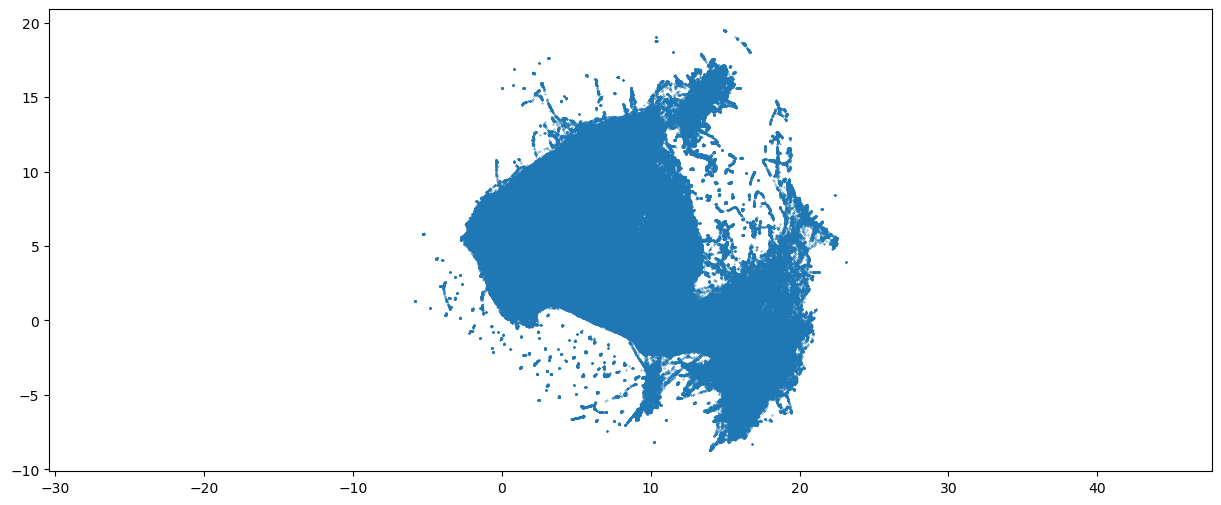

In [223]:
plt.scatter(
    standard_embedding[:, 0],
    standard_embedding[:, 1],
    s=0.1)
plt.gca().set_aspect('equal', 'datalim')

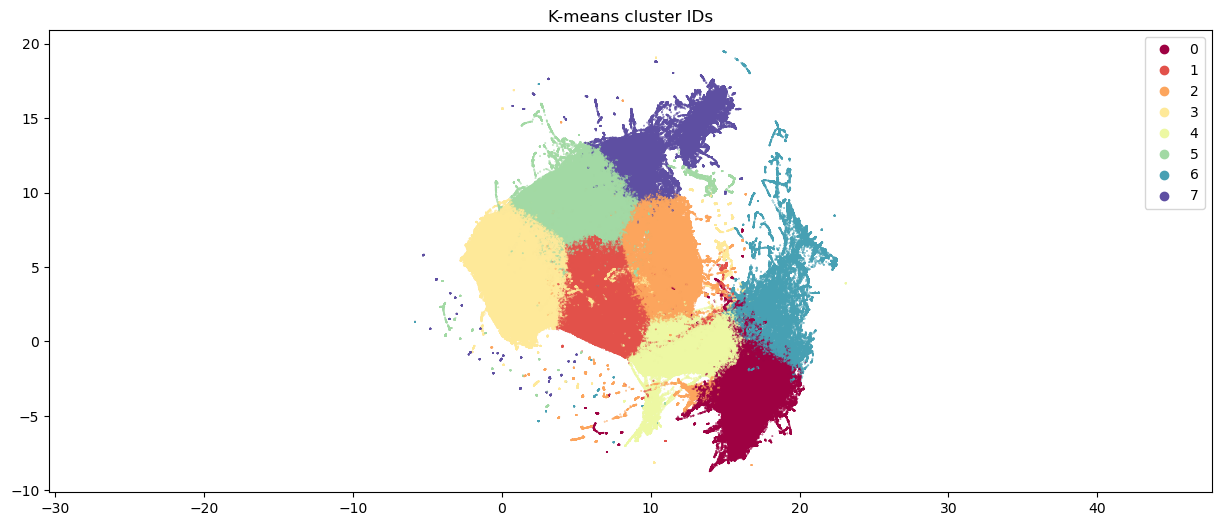

In [224]:
umap_cluster = plt.scatter(
    standard_embedding[:, 0],
    standard_embedding[:, 1],
    s=0.1,
    c=kmeans_label_zscore,
    cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.legend(*umap_cluster.legend_elements())
plt.title("K-means cluster IDs")
plt.savefig("./proc/kmeans_cluster_ids.png")


In [225]:
exploded_columns

frame_index tone_frame  \
0       [1538, 1539, 1540, 1541, 1542, 1543, 1544, 154...          0   
1       [1538, 1539, 1540, 1541, 1542, 1543, 1544, 154...          1   
2       [1538, 1539, 1540, 1541, 1542, 1543, 1544, 154...          2   
3       [1538, 1539, 1540, 1541, 1542, 1543, 1544, 154...          3   
4       [1538, 1539, 1540, 1541, 1542, 1543, 1544, 154...          4   
...                                                   ...        ...   
535765  [68246, 68247, 68248, 68249, 68250, 68251, 682...        594   
535766  [68246, 68247, 68248, 68249, 68250, 68251, 682...        595   
535767  [68246, 68247, 68248, 68249, 68250, 68251, 682...        596   
535768  [68246, 68247, 68248, 68249, 68250, 68251, 682...        597   
535769  [68246, 68247, 68248, 68249, 68250, 68251, 682...        598   

                                              session_dir  tone_start_frame  \
0                20240227_130241_comp_om_subj_4-2_and_4-3              1737   
1                20240227_130241_comp_om_subj_4-2_and_4-3              1737   
2                20240227_130241_comp_om_subj_4-2_and_4-3              1737   
3                20240227_130241_comp_om_subj_4-2_and_4-3              1737   
4                20240227_130241_comp_om_subj_4-2_and_4-3              1737   
...                                                   ...               ...   
535765  20230621_111240_standard_comp_to_omission_D5_s...             68445   
535766  20230621_111240_standard_comp_to_omission_D5_s...             68445   
535767  20230621_111240_standard_comp_to_omission_D5_s...             68445   
535768  20230621_111240_standard_comp_to_omission_D5_s...             68445   
535769  20230621_111240_standard_comp_to_omission_D5_s...             68445   

        reward_start  reward_dispensed  tone_stop_frame condition   \
0                NaN               NaN             1988        tbd   
1                NaN               NaN             1988        tbd   
2                NaN               NaN             1988        tbd   
3                NaN               NaN             1988        tbd   
4                NaN               NaN             1988        tbd   
...              ...               ...              ...        ...   
535765           NaN               NaN            68644   rewarded   
535766           NaN               NaN            68644   rewarded   
535767           NaN               NaN            68644   rewarded   
535768           NaN               NaN            68644   rewarded   
535769           NaN               NaN            68644   rewarded   

       competition_closeness     notes  ... agent_nose_to_reward_port  \
0                        NaN       NaN  ...                 26.282446   
1                        NaN       NaN  ...                 26.287552   
2                        NaN       NaN  ...                 26.358633   
3                        NaN       NaN  ...                 26.429934   
4                        NaN       NaN  ...                   26.4245   
...                      ...       ...  ...                       ...   
535765                   NaN  rewarded  ...                  2.904891   
535766                   NaN  rewarded  ...                  2.897348   
535767                   NaN  rewarded  ...                  3.120636   
535768                   NaN  rewarded  ...                  3.027167   
535769                   NaN  rewarded  ...                  3.021599   

       agent_thorax_velocity agent_to_reward_port_angle current_frame  \
0                    0.07875                   1.695231          1538   
1                   0.076889                   1.712732          1539   
2                   0.086355                   1.701264          1540   
3                   0.096433                   1.704137          1541   
4                   0.106222                   1.704675          1542   
...                      ...                        ...           ...   
535

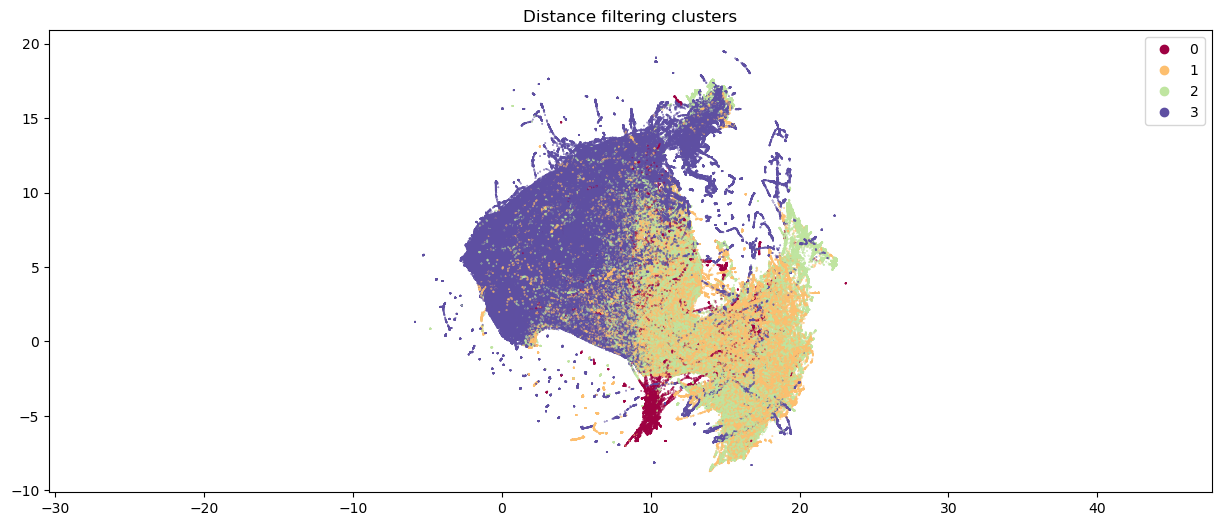

In [226]:
umap_cluster = plt.scatter(
    standard_embedding[:, 0],
    standard_embedding[:, 1],
    s=0.1,
    c=exploded_columns["manual_cluster_id"],
    cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.legend(*umap_cluster.legend_elements())
plt.title("Distance filtering clusters")
plt.savefig("./proc/filtered_cluster_ids.png")


In [227]:
exploded_columns["video_name"].unique()

array(['20240227_130241_comp_om_subj_4-2_and_4-3.1',
       '20240228_142038_comp_om_subj_3-1_and_3-3.1',
       '20240228_154053_comp_om_subj_4-3_and_4-4.1',
       '20240229_152936_comp_om_subj_3-3_and_3-4.1',
       '20240317_105929_comp_om_subj_5-3_and_5-4.1',
       '20240318_115841_comp_om_subj_5-2_and_5-3.1',
       '20240319_111204_comp_om_subj_5-2_and_5-4.1',
       '20240325_125522_comp_om_subj_3-1_and_3-4.1',
       '20240325_150329_comp_om_subj_4-2_and_4-4.1',
       '20240317_151922_long_comp_subj_3-1_and_3-3.1',
       '20240317_172017_long_comp_subj_4-2_and_4-3.1',
       '20240318_143819_long_comp_subj_3-3_and_3-4.1',
       '20240318_170933_long_comp_subj_4-3_and_4-4.1',
       '20240319_134914_long_comp_subj_3-1_and_3-4.1',
       '20240319_160457_long_comp_subj_4-2_and_4-4.1',
       '20240320_114629_long_comp_subj_5-3_and_5-4.1',
       '20240321_114851_long_comp_subj_5-2_and_5-3.1',
       '20240320_171038_alone_comp_subj_4-2_and_4-3.1',
       '20240322_120625_alo

In [228]:
exploded_columns["video_id"], unique = pd.factorize(exploded_columns['video_name'])


In [229]:
unique

Index(['20240227_130241_comp_om_subj_4-2_and_4-3.1',
       '20240228_142038_comp_om_subj_3-1_and_3-3.1',
       '20240228_154053_comp_om_subj_4-3_and_4-4.1',
       '20240229_152936_comp_om_subj_3-3_and_3-4.1',
       '20240317_105929_comp_om_subj_5-3_and_5-4.1',
       '20240318_115841_comp_om_subj_5-2_and_5-3.1',
       '20240319_111204_comp_om_subj_5-2_and_5-4.1',
       '20240325_125522_comp_om_subj_3-1_and_3-4.1',
       '20240325_150329_comp_om_subj_4-2_and_4-4.1',
       '20240317_151922_long_comp_subj_3-1_and_3-3.1',
       '20240317_172017_long_comp_subj_4-2_and_4-3.1',
       '20240318_143819_long_comp_subj_3-3_and_3-4.1',
       '20240318_170933_long_comp_subj_4-3_and_4-4.1',
       '20240319_134914_long_comp_subj_3-1_and_3-4.1',
       '20240319_160457_long_comp_subj_4-2_and_4-4.1',
       '20240320_114629_long_comp_subj_5-3_and_5-4.1',
       '20240321_114851_long_comp_subj_5-2_and_5-3.1',
       '20240320_171038_alone_comp_subj_4-2_and_4-3.1',
       '20240322_120625_alo

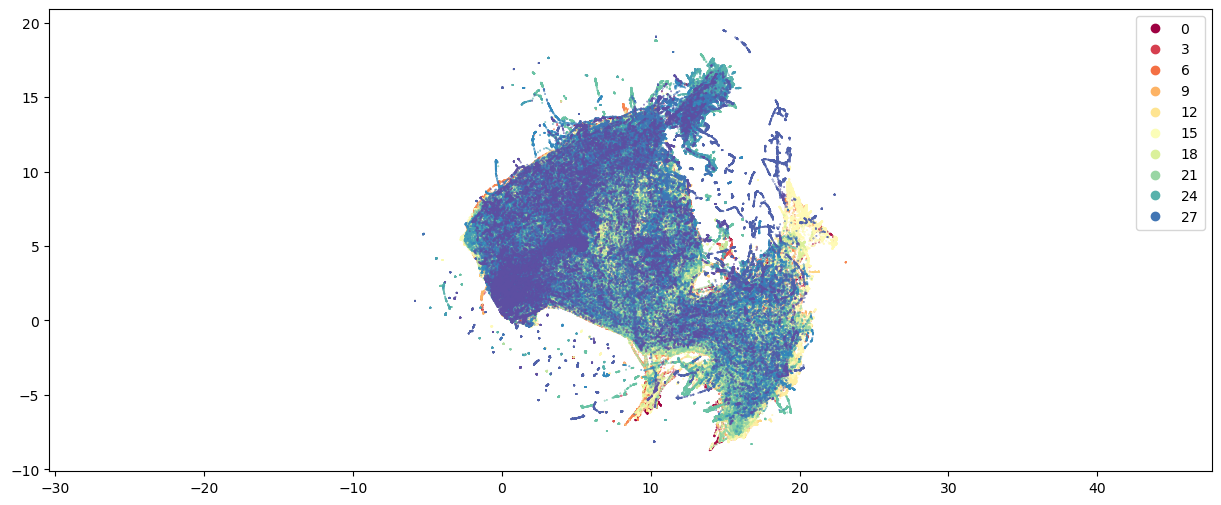

In [230]:
umap_cluster = plt.scatter(
    standard_embedding[:, 0],
    standard_embedding[:, 1],
    s=0.1,
    c=exploded_columns["video_id"],
    cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.legend(*umap_cluster.legend_elements())
plt.savefig("./proc/video_cluster_ids.png")



## Looking at metrics

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

In [232]:
cmap = cm.viridis  # Choose a colormap

In [233]:
features_columns

['subject_thorax_to_agent_thorax',
 'thorax_to_reward_port_sum',
 'thorax_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle']

subject_thorax_to_agent_thorax


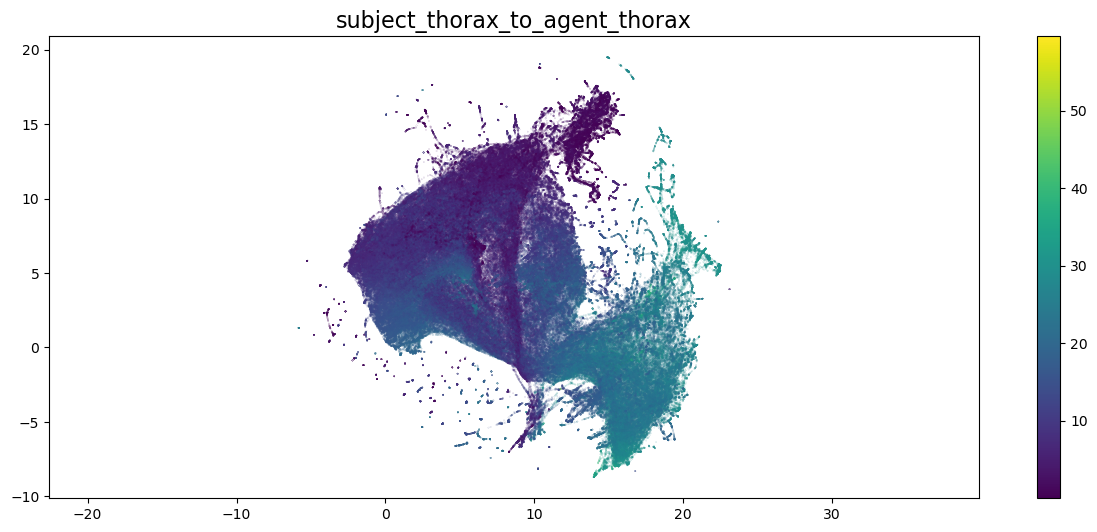

thorax_to_reward_port_sum


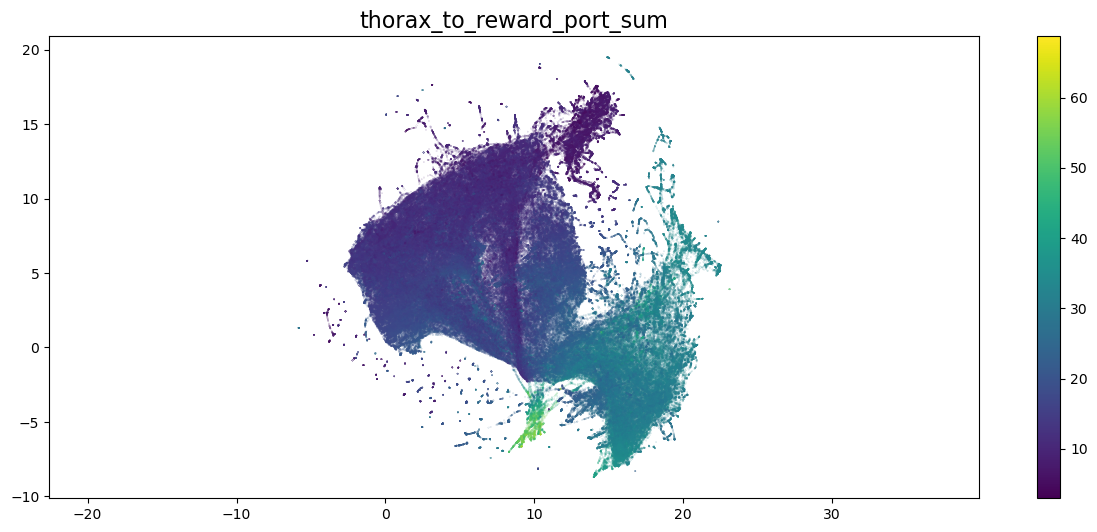

thorax_to_reward_port_diff


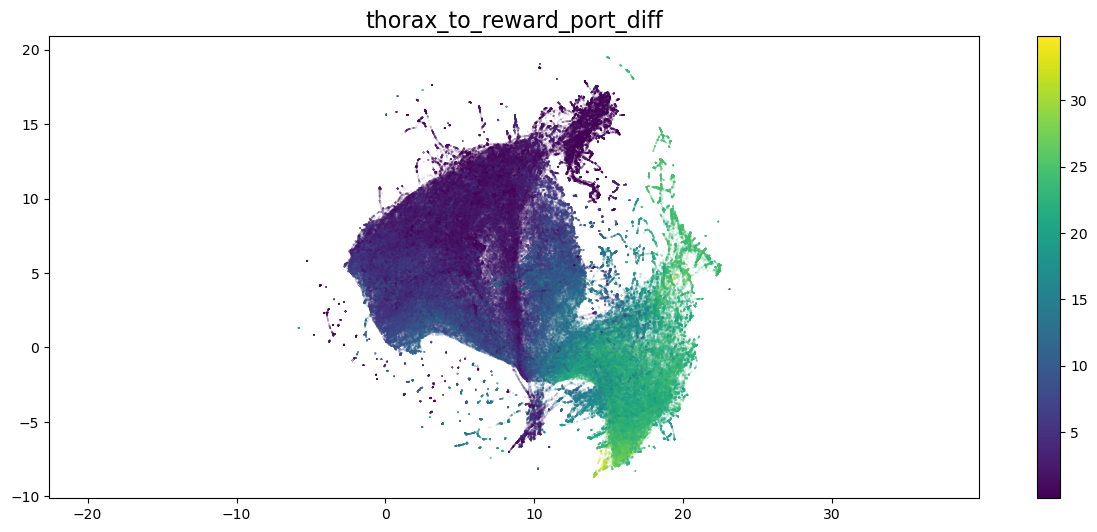

thorax_velocity_sum


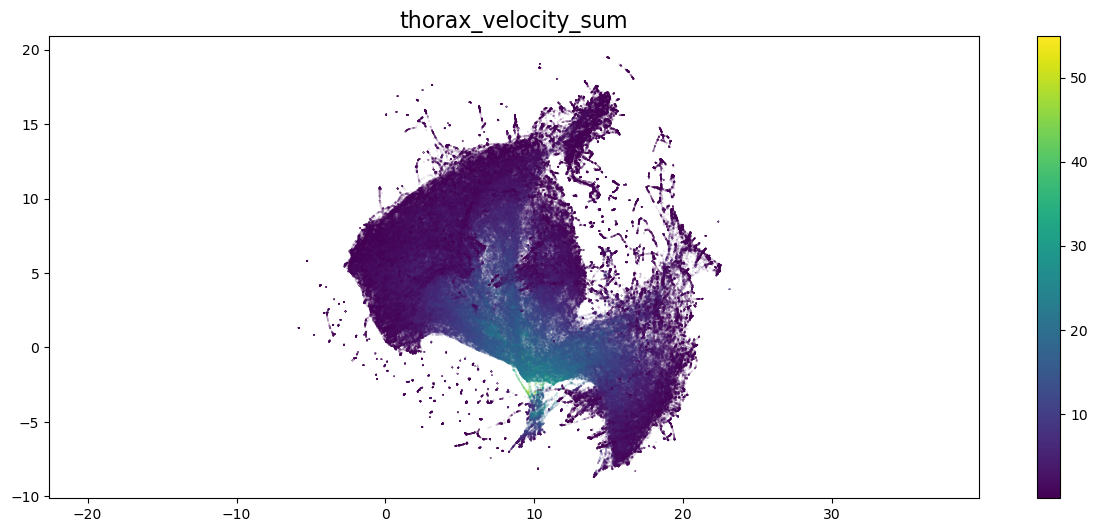

thorax_velocity_diff


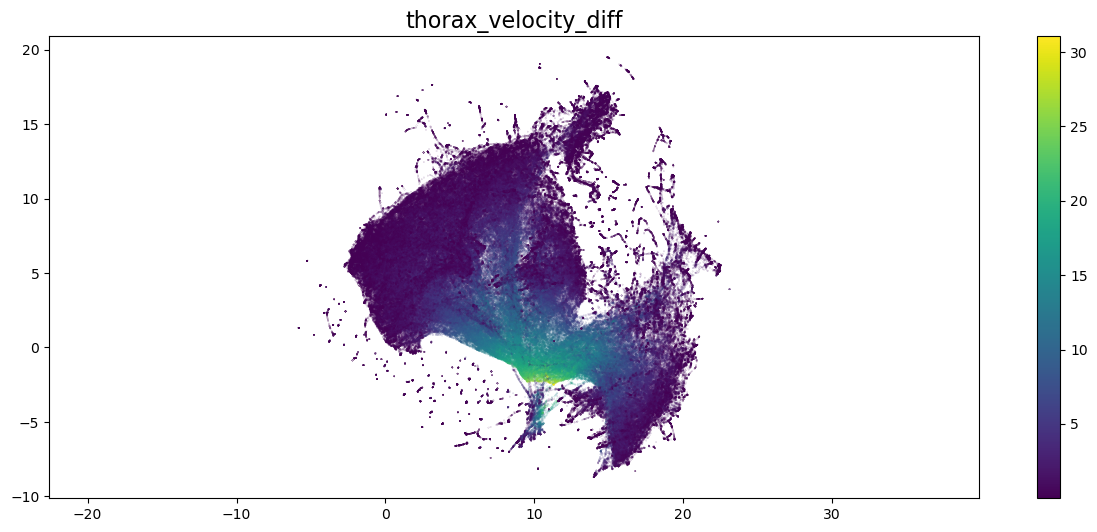

to_reward_port_angle_sum


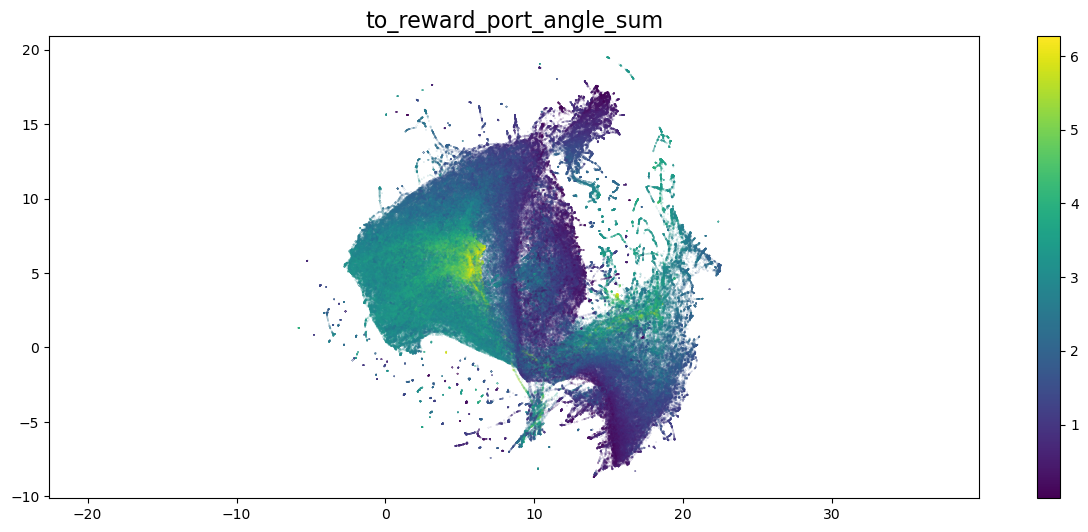

to_reward_port_angle_diff


subject_nose_to_reward_port


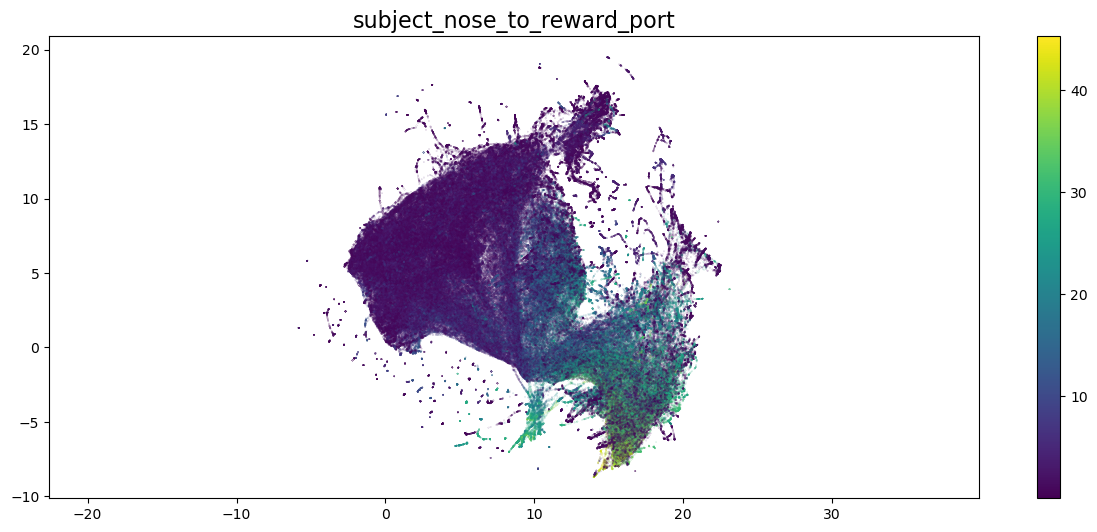

subject_thorax_velocity


subject_to_reward_port_angle


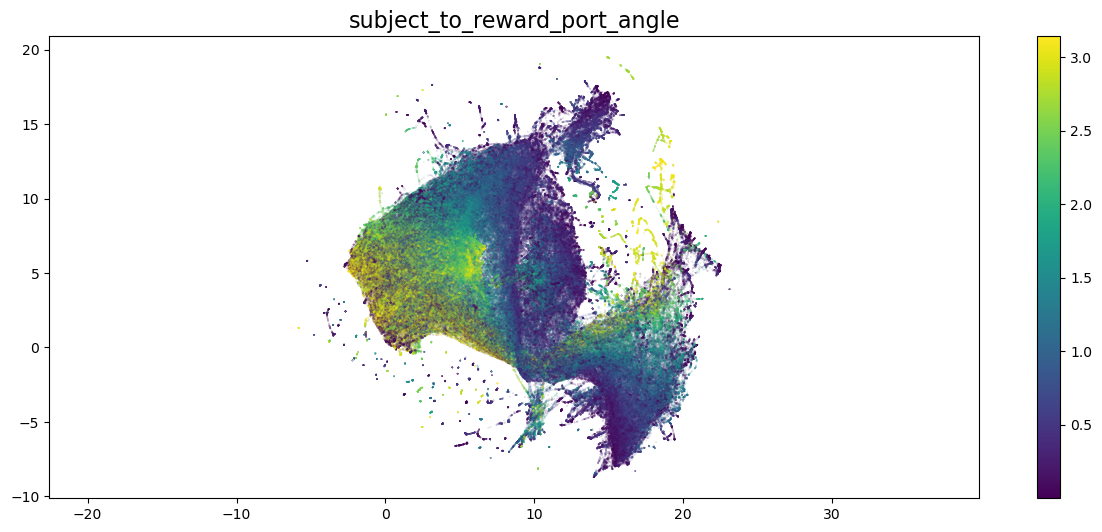

agent_nose_to_reward_port


agent_thorax_velocity


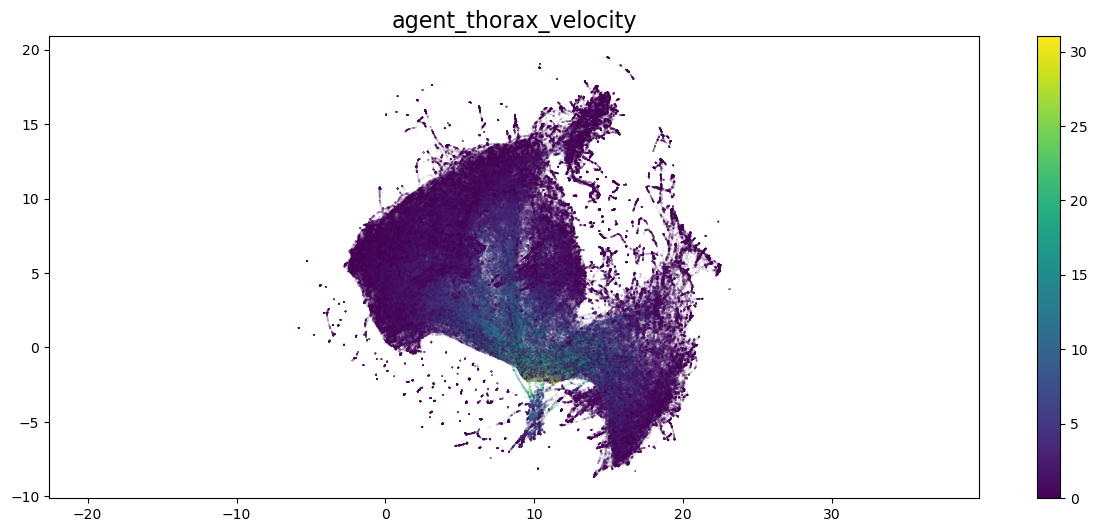

agent_to_reward_port_angle


In [234]:
for featured in features_columns:
    if featured == "frame_index":
        continue
    print(featured)
    fig, ax = plt.subplots()
    norm = Normalize(vmin=np.min(exploded_columns[featured].astype(float)), vmax=np.max(exploded_columns[featured].astype(float)))  # Normalize to the data range
    plt.scatter(
        standard_embedding[:, 0],
        standard_embedding[:, 1],
        c=exploded_columns[featured].astype(float),
        s=0.005, cmap = cmap, norm=norm)

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(featured, fontsize= 16)
    plt.colorbar(orientation="vertical")
    plt.savefig("./proc/{}_umap.png".format(featured))
    plt.show()

# Looking at the clusters

In [236]:
for vid in exploded_columns["video_name"].unique():
    video_df = exploded_columns[exploded_columns["video_name"] == vid]

    for cluster in video_df["kmeans_cluster"].unique():
        cluster_df = video_df[video_df["kmeans_cluster"] == cluster]
    
        video_name = "{}.fixed.mp4".format(vid)
        video_path = os.path.join("/scratch/back_up/reward_competition_extention/in_progress/rce3/sleap_id_correction/to_be_checked", video_name)
        
        frame_numbers = cluster_df["current_frame"].sample(n=100, random_state=1).sort_values().to_list()
        Path("./proc/kmeans/{}/{}".format(cluster, video_name)).mkdir(parents=True, exist_ok=True)
        frames_path = extract_frames(video_path, frame_numbers, "./proc/kmeans/{}/{}".format(cluster, video_name), max_width=640)

Extracted frame 1562
Extracted frame 1575
Extracted frame 1604
Extracted frame 1606
Extracted frame 1794
Extracted frame 1795
Extracted frame 1804
Extracted frame 1808
Extracted frame 1852
Extracted frame 4534
Extracted frame 4535
Extracted frame 4541
Extracted frame 4566
Extracted frame 4568
Extracted frame 4575
Extracted frame 4662
Extracted frame 4673
Extracted frame 4704
Extracted frame 4920
Extracted frame 4922
Extracted frame 4936
Extracted frame 7401
Extracted frame 7439
Extracted frame 7443
Extracted frame 7612
Extracted frame 7673
Extracted frame 7676
Extracted frame 8005
Extracted frame 9718
Extracted frame 9728
Extracted frame 9807
Extracted frame 9811
Extracted frame 9820
Extracted frame 9826
Extracted frame 9840
Extracted frame 9847
Extracted frame 9861
Extracted frame 9870
Extracted frame 9877
Extracted frame 9895
Extracted frame 9904
Extracted frame 10145
Extracted frame 10146
Extracted frame 10169
Extracted frame 10171
Extracted frame 11035
Extracted frame 11044
Extract

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
for cluster_dir in glob.glob("/nancy/user/riwata/projects/reward_comp_ext/results/2024_06_26_sleap_clustering/proc/kmeans/*"):
    print(cluster_dir)
    cluster = cluster_dir.split("/")[-1]
    frame_glob = os.path.join(cluster_dir, "*/*.png")
    frame_paths = sorted(glob.glob(frame_glob))
    make_video(frame_paths=frame_paths, output_folder=cluster_dir, video_name="kmeans_cluster_{}.avi".format(cluster))






In [ ]:
raise ValueError()

In [ ]:
for vid in exploded_columns["video_name"].unique():
    video_df = exploded_columns[exploded_columns["video_name"] == vid]

    for cluster in video_df["kmeans_cluster"].unique():
        cluster_df = video_df[video_df["kmeans_cluster"] == cluster]
    
        video_name = "{}.fixed.mp4".format(vid)
        video_path = os.path.join("/scratch/back_up/reward_competition_extention/in_progress/rce3/sleap_id_correction/to_be_checked", video_name)
        
        frame_numbers = cluster_df["current_frame"].to_list()[:500]
        Path("./proc/{}/{}".format(cluster, video_name)).mkdir(parents=True, exist_ok=True)
        extract_frames_and_make_gif(video_path, frame_numbers, "./proc/{}/{}".format(cluster, video_name), gif_name="cluster_{}_{}.gif".format(cluster, video_name), fps=25, max_width=640)

In [ ]:
raise ValueError()

In [ ]:
raise ValueError()

## Putting together LFP and video start/stop

In [ ]:
START_STOP_FRAME_DF["video_name"].unique()[:5]

In [ ]:
LFP_SPECTRAL_DF["video_name"].unique()[:5]

In [ ]:
LFP_SPECTRAL_DF["current_subject"].unique()

In [ ]:
START_STOP_FRAME_DF["current_subject"].unique()

In [ ]:
LFP_AND_SLEAP_DF = pd.merge(LFP_SPECTRAL_DF, START_STOP_FRAME_DF, on=["video_name", "current_subject"], how="inner")

In [ ]:
LFP_AND_SLEAP_DF["video_timestamps"].apply(lambda x: x.shape).head()

In [ ]:
LFP_AND_SLEAP_DF.head()

- Checking if any of the velocities contain Nans

In [ ]:
LFP_AND_SLEAP_DF[LFP_AND_SLEAP_DF["subject_thorax_velocity"].apply(lambda x: np.isnan(x).any())]

## Exporting

In [ ]:
LFP_AND_SLEAP_DF.columns

In [ ]:
FULL_LFP_TRACES_PKL

In [ ]:
LFP_AND_SLEAP_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [ ]:
LFP_AND_SLEAP_DF.head()

In [ ]:
for col in LFP_AND_SLEAP_DF.columns:
    print(col)

In [ ]:
raise ValueError()